In [2]:
#!pip3 install statsmodels
!pip3 install pydot


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
%matplotlib inline
import pymc as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import arviz as az
import pydot
from IPython.display import Image, display

%config InlineBackend.figure_format = 'retina'

plt.style.use(['seaborn-v0_8-darkgrid','seaborn-v0_8-colorblind'])

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


#### Figure 5.2

#### Code 5.1

In [47]:
# load data and copy
data = pd.read_csv('Data/WaffleDivorce.csv', sep=';')
d = data

# standardize variables
d['A'] = (d.Marriage - d.Marriage.mean()) / d.Marriage.std()
d['D'] = (d.Divorce - d.Divorce.mean()) / d.Divorce.std()
d['M'] = (d.Marriage - d.Marriage.mean()) / d.Marriage.std()

d.head(4)

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,A,D,M
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,-0.606290,1.654205,0.022644
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,-0.686699,1.544364,1.549802
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,-0.204241,0.610716,0.048974
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,-1.410387,2.093569,1.655123


#### Code 5.2

In [6]:
sd = d.MedianAgeMarriage.std()

sd

1.2436303013880823

#### Code 5.3

In [48]:
with pm.Model() as m5_1:
    sigma = pm.Exponential('s', 1)
    bA = pm.Normal('bA', mu = 0, sigma = .5)
    a = pm.Normal('a', mu = 0, sigma = .2)
    mu = pm.Deterministic('mu', a + bA * d.A)

    D_i = pm.Normal('D_i', mu = mu, sigma = sigma, observed = d.D)

    m5_1_prior = pm.sample_prior_predictive(1000)

    m5_1_trace = pm.sample(1000)

    m5_1_samples = pm.sample_posterior_predictive(m5_1_trace)


Sampling: [D_i, a, bA, s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Sampling: [D_i]


#### Code 5.4

Text(0, 0.5, 'Divorce (std)')

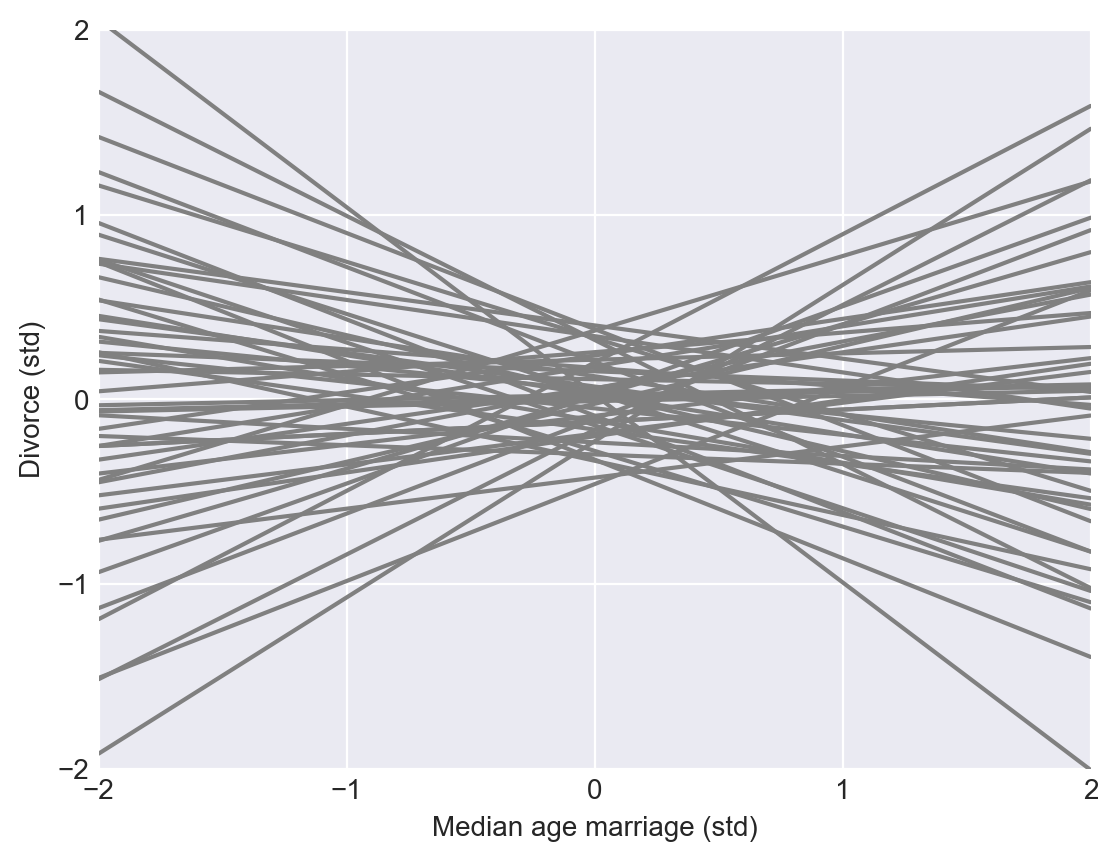

In [43]:
seed = 50

x_range = np.linspace(-2,2, m5_1_prior.prior.sizes['draw'])


prior_df = m5_1_prior.prior.to_dataframe()


for _, row in prior_df.sample(seed).iterrows():
    y = row.a + row.bA * x_range
    plt.plot(x_range, y, color = 'grey')

plt.xticks([-2,-1,0,1,2])
plt.xlim(-2,2)
plt.xlabel('Median age marriage (std)')
plt.yticks([-2,-1,0,1,2])
plt.ylim(-2,2)
plt.ylabel('Divorce (std)')

#### Code 5.5

/var/folders/v0/f2hcx8fs7_z5zrx8d8tr410r0000gn/T/ipykernel_20534/2936048929.py:5: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  m5_1_mu_hdi = az.hdi(f52a_trace.posterior.mu.sel(chain = 1).values[age_idx], hdi_prob = .89)


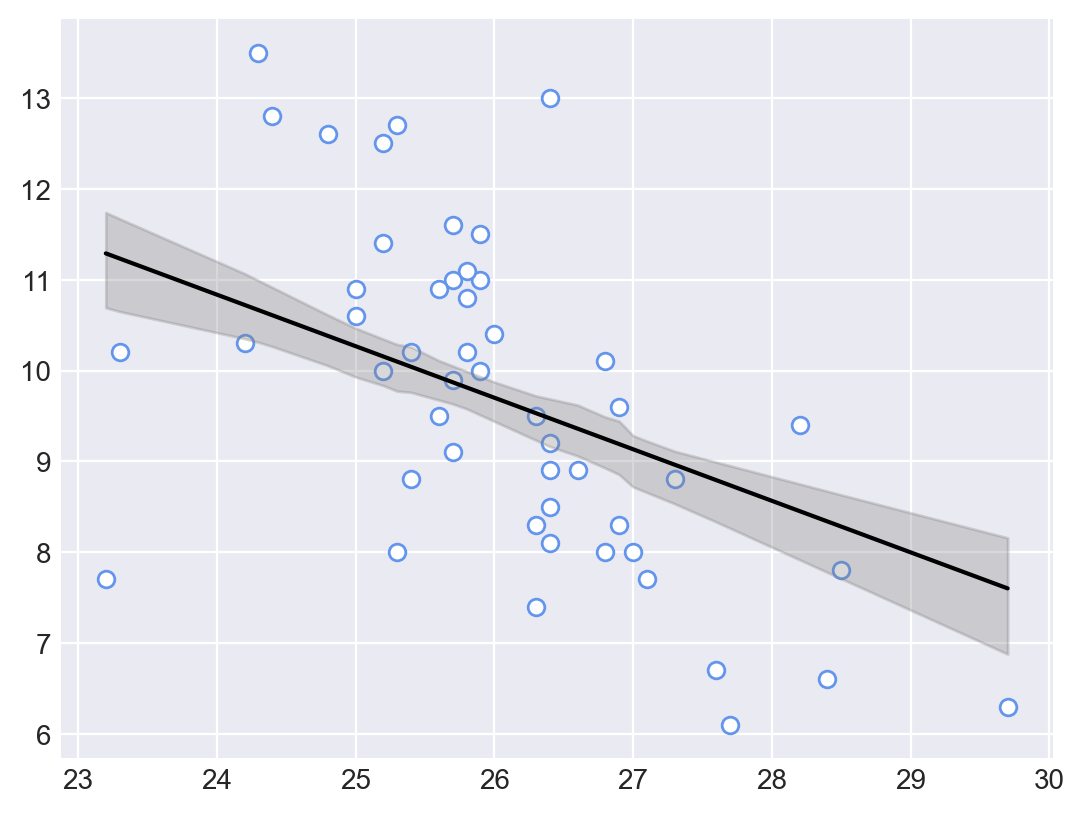

In [54]:

age_idx = np.argsort(d.MedianAgeMarriage)
age_sort = np.sort(d.MedianAgeMarriage)

m5_1_mu_means = f52a_trace.posterior.mu.sel(chain = 1).values.mean(0)
m5_1_mu_hdi = az.hdi(f52a_trace.posterior.mu.sel(chain = 1).values[age_idx], hdi_prob = .89)


plt.scatter(d.MedianAgeMarriage, d.Divorce, edgecolors = 'cornflowerblue', facecolors='white');
plt.plot(age_sort, m5_1_mu_means[age_idx], color = 'black');
plt.fill_between(age_sort, m5_1_mu_hdi[:,0][age_idx], m5_1_mu_hdi[:,1][age_idx], color='grey', alpha =.3);

#### Code 5.6

Sampling: [D_i, a, bM, s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, bM, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Sampling: [D_i]


/var/folders/v0/f2hcx8fs7_z5zrx8d8tr410r0000gn/T/ipykernel_20534/263609707.py:20: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  m5_2_mu_hdi = az.hdi(m5_2_trace.posterior.mu.sel(chain = 1).values[rate_idx], hdi_prob = .89)


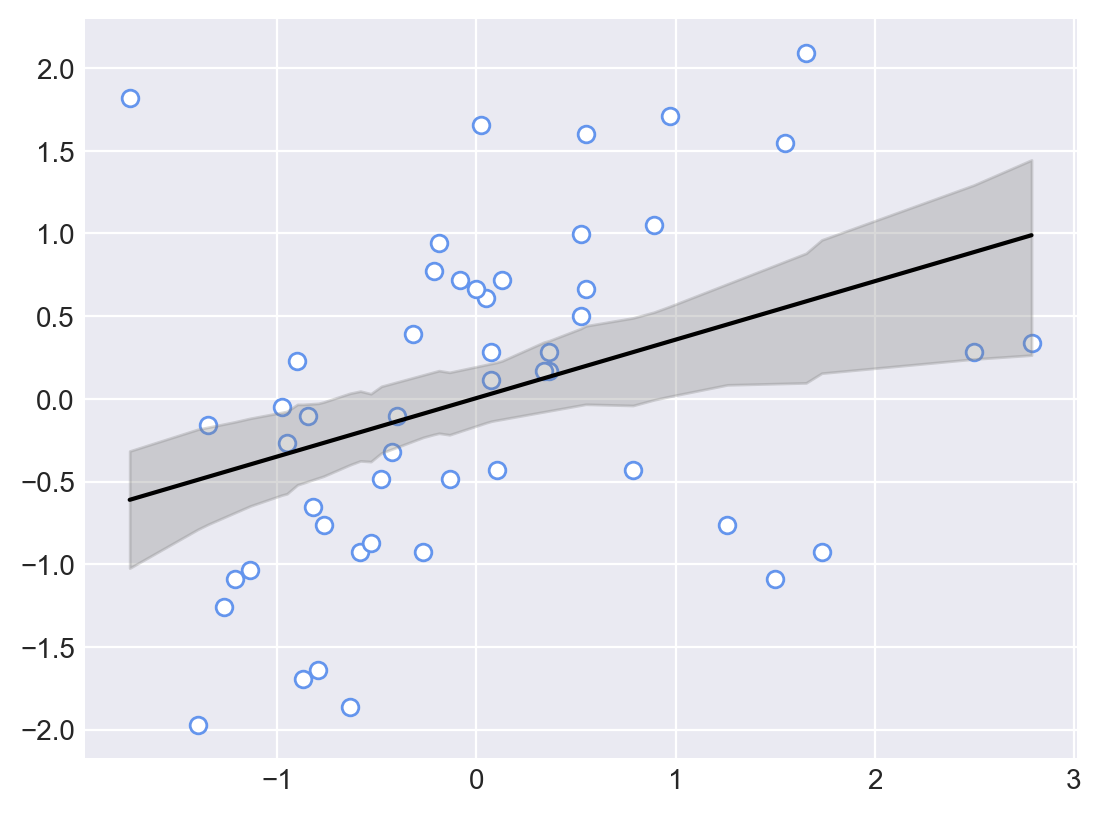

In [55]:
with pm.Model() as m5_2:
    sigma = pm.Exponential('s', 1)
    bM = pm.Normal('bM', mu = 0, sigma = .5)
    a = pm.Normal('a', mu = 0, sigma = .2)
    mu = pm.Deterministic('mu', a + bM * d.M)

    D_i = pm.Normal('D_i', mu = mu, sigma = sigma, observed = d.D)

    m5_2_prior = pm.sample_prior_predictive(1000)

    m5_2_trace = pm.sample(1000)

    m5_2_samples = pm.sample_posterior_predictive(m5_2_trace)


rate_idx = np.argsort(d.M)
rate_sort = np.sort(d.M)

m5_2_mu_means = m5_2_trace.posterior.mu.sel(chain = 1).values.mean(0)
m5_2_mu_hdi = az.hdi(m5_2_trace.posterior.mu.sel(chain = 1).values[rate_idx], hdi_prob = .89)

plt.scatter(d.M, d.D, edgecolors = 'cornflowerblue', facecolors='white');
plt.plot(rate_sort, m5_2_mu_means[rate_idx], color = 'black');
plt.fill_between(rate_sort, m5_2_mu_hdi[:,0][rate_idx], m5_2_mu_hdi[:,1][rate_idx], color='grey', alpha =.3);

#### Code 5.7

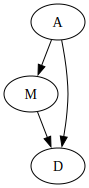

[]

In [11]:
from causalgraphicalmodels import CausalGraphicalModel #This is what we'll use instead of dagitty

model = CausalGraphicalModel(
    nodes=["A", "M", "D"],
    edges=[("A", "M"), ("A", "D"), ("M","D")],
)

# List conditional independencies implied by the DAG
display(model.draw())
model.get_all_independence_relationships() #{A} can be read as 'conditional on A.'  If there is no conditional dependency you'll get a []

#### Code 5.8

[('M', 'D', {'A'})]


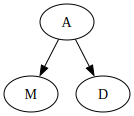

In [12]:
from causalgraphicalmodels import CausalGraphicalModel

# Define the DAG
model = CausalGraphicalModel(
    nodes=["A", "M", "D"],
    edges=[("A", "M"), ("A", "D")],

)

# List conditional independencies implied by the DAG
print(model.get_all_independence_relationships())
model.draw()



#### Code 5.9

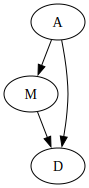

[]

In [13]:
model = CausalGraphicalModel(
    nodes=["A", "M", "D"],
    edges=[("A", "M"), ("A", "D"), ("M","D")],
)

# List conditional independencies implied by the DAG
display(model.draw())
model.get_all_independence_relationships()

#### Code 5.10

In [37]:
with pm.Model() as m5_3:
    sigma = pm.Exponential('sigma', 1)
    bA = pm.Normal('bA', mu = 0, sigma = .5)
    bM = pm.Normal('bM', mu = 0, sigma = .5)
    a = pm.Normal('a', mu = 0, sigma = .2)
    mu = pm.Deterministic('mu', a + bA * d.A + bM * d.Marriage)

    D_i = pm.Normal('D_i', mu = mu, sigma = sigma, observed = d.D)

    m5_3_prior = pm.sample_prior_predictive(1000)

    m5_3_trace = pm.sample(1000)

    m5_3_samples = pm.sample_posterior_predictive(m5_1_trace)

m5_3_df = m5_3_trace.posterior.to_dataframe().reset_index()

(m5_3_df[['a','bA','bM','sigma']].describe())

Sampling: [D_i, a, bA, bM, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, bM, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [D_i, bA, sigma]


,a,bA,bM,sigma
count,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.023702,-0.572655,-0.001585,0.823016
std,0.200439,0.116683,0.011359,0.086759
min,-0.633242,-0.957188,-0.047312,0.572927
25%,-0.109437,-0.655896,-0.009052,0.763710
50%,0.020265,-0.570079,-0.001278,0.817494
75%,0.155484,-0.492989,0.006051,0.875286
max,0.789279,-0.142157,0.035725,1.193127


#### Code 5.11

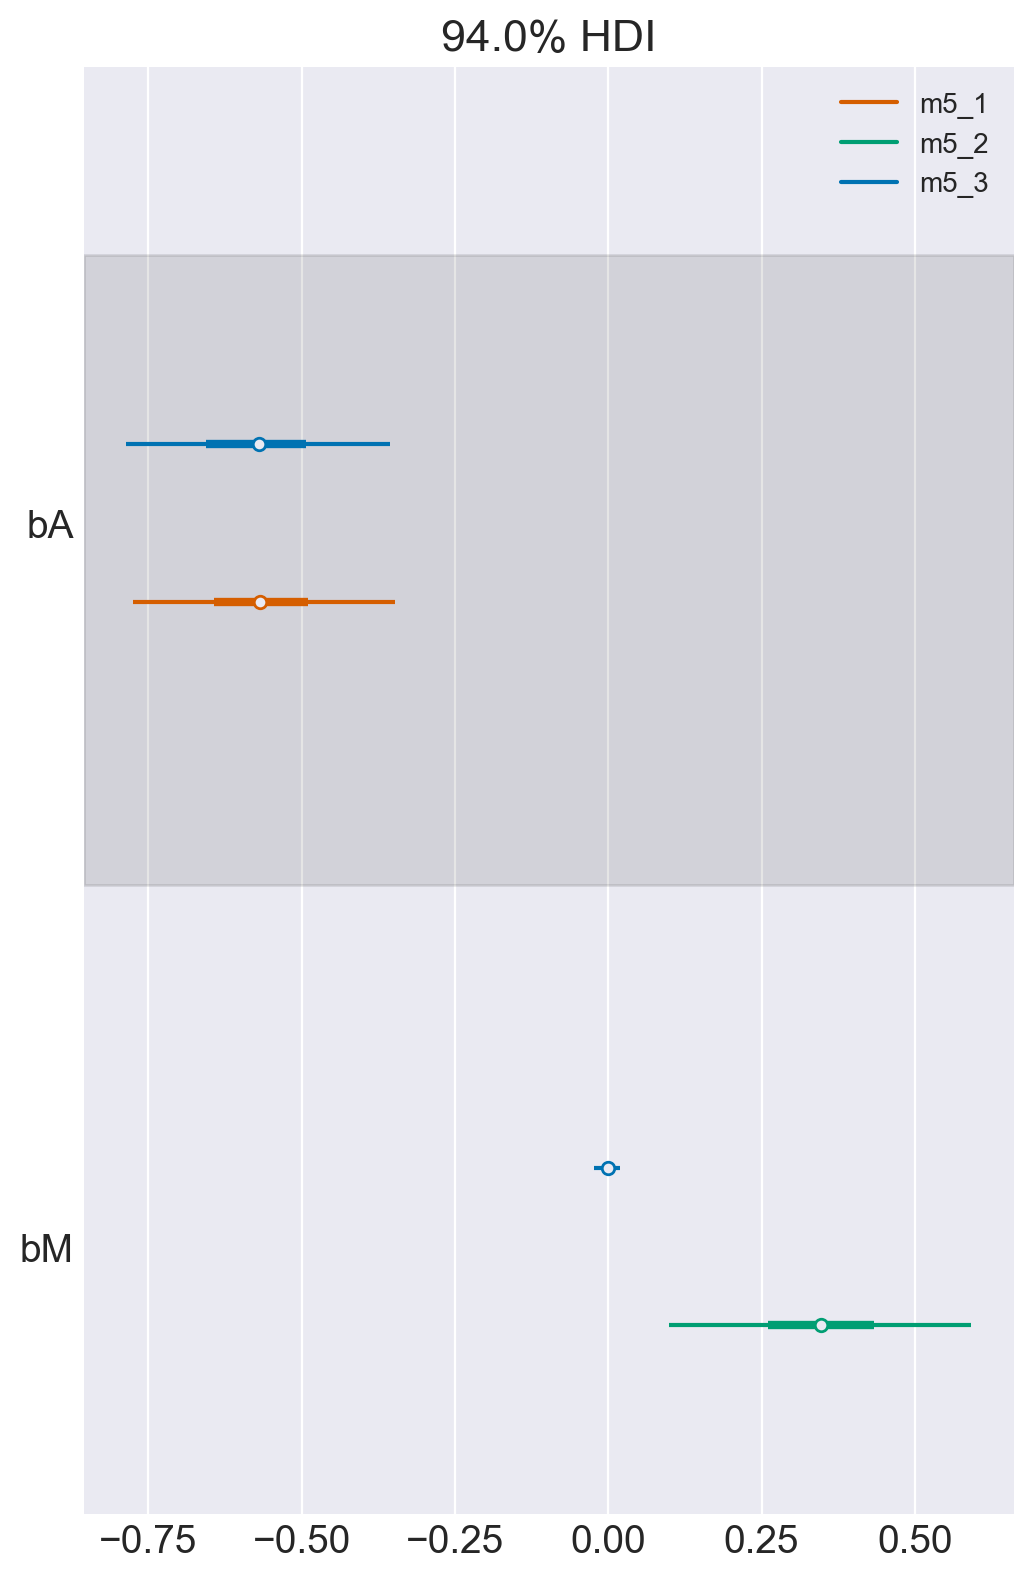

In [57]:
az.plot_forest(
    [m5_3_trace, m5_2_trace, m5_1_trace],
    var_names=['bA', 'bM'],
    combined=True,  # Combines chains
    model_names=["m5_3", "m5_2", "m5_1"],  # Labels for each trace
    #ridgeplot_overlap=1.5  # Adjusts overlap for clarity
);

#### Code 5.12

In [ ]:
n = 50
age = stats.norm.rvs(0,1,n)
mar = stats.norm.rvs(-age,1,n)
div = stats.norm.rvs(age, 1, n)



#### Code 5.13

In [210]:
with pm.Model() as m5_4:
    sigma = pm.Exponential('sigma', 1)
    a = pm.Normal('a', mu = 0, sigma = .2)
    bAM = pm.Normal('bAM', mu = 0, sigma = .5)
    mu = pm.Deterministic('mu', a + bAM * d.A)

    M = pm.Normal('M', mu = mu, sigma = sigma, observed = d.M)

    m5_4_trace = pm.sample(1000)
    m5_4_posterior_samples = pm.sample_posterior_predictive(m5_4_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a, bAM]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Sampling: [M]


#### Code 5.14

In [203]:
m5_4_mu_means = m5_4_trace.posterior.mu.sel(chain = 1).values.mean(0)

m5_4_mu_resid = d.M - m5_4_mu_means

#### Figure 5.4

In [ ]:
with pm.Model() as m5_4a:
    sigma = pm.Exponential('sigma', 1)
    a = pm.Normal('a', mu = 0, sigma = .2)
    bA = pm.Normal('bAM', mu = 0, sigma = .5)
    mu = pm.Deterministic('mu', a + bA * d.A)

    M = pm.Normal('M', mu = mu, sigma = sigma, observed = d.M)

    m5_4a_trace = pm.sample(1000)

with pm.Model() as m5_4r:
    sigma = pm.Exponential('sigma', 1)
    a = pm.Normal('a', mu = 0, sigma = .2)
    bM = pm.Normal('bAM', mu = 0, sigma = .5)
    mu = pm.Deterministic('mu', a + bM * d.M)

    M = pm.Normal('M', mu = mu, sigma = sigma, observed = d.A)

    m5_4r_trace = pm.sample(1000)

m5_4_mu_means = m5_4_trace.posterior.mu.sel(chain = 1).values.mean(0)

m5_4_mu_resid = d.M - m5_4_mu_means

m5_3_mu_means = m5_3_trace.posterior.mu.sel(chain = 1).values.mean(0)

m5_3_mu_resid = d.A - m5_3_mu_means


with pm.Model() as m5_4resid:
    sigma = pm.Exponential('sigma', 1)
    a = pm.Normal('a', mu = 0, sigma = .2)
    bM_resid = pm.Normal('bM_resid', mu = 0, sigma = .5)
    mu = pm.Deterministic('mu', a + bM_resid * m5_4_mu_resid)

    M = pm.Normal('M', mu = mu, sigma = sigma, observed = d.D)

    m5_4_resid_trace = pm.sample(1000)    

with pm.Model() as m5_3resid:
    sigma = pm.Exponential('sigma', 1)
    a = pm.Normal('a', mu = 0, sigma = .2)
    bM_resid = pm.Normal('bM_resid', mu = 0, sigma = .5)
    mu = pm.Deterministic('mu', a + bM_resid * m5_3_mu_resid)

    M = pm.Normal('M', mu = mu, sigma = sigma, observed = d.D)

    m5_3_resid_trace = pm.sample(1000)    

m5_4_resid_idx = np.argsort(m5_4_mu_resid)
m5_4_resid_mus = m5_4_resid_trace.posterior.mu.sel(chain = 1).values
m5_4_resid_means =m5_4_resid_mus.mean(0)
m5_4_resid_pi = az.hdi(m5_4_resid_mus, hdi_prob = .89)

m5_3_resid_idx = np.argsort(m5_3_mu_resid)
m5_3_resid_mus = m5_3_resid_trace.posterior.mu.sel(chain = 1).values
m5_3_resid_means =m5_3_resid_mus.mean(0)
m5_3_resid_pi = az.hdi(m5_3_resid_mus, hdi_prob = .89)

a_idx = np.argsort(d.A)
m5_4a_mu_means = m5_4a_trace.posterior.mu.sel(chain = 1).values.mean(0)

r_idx = np.argsort(d.M)
m5_4r_mu_means = m5_4r_trace.posterior.mu.sel(chain = 1).values.mean(0)

_, ax = plt.subplots(2, 2, figsize = [13,10]);


ax[0,0].plot(d.A[a_idx], m5_4a_mu_means[a_idx], color = 'black');
ax[0,0].set_xlim(-2.4,3);
ax[0,0].set_xlabel('Age at marriage (std)')
ax[0,0].set_ylabel('Marriage rate (std)')
ax[0,0].vlines(d.A, m5_4a_mu_means, d.M, color = 'black')
ax[0,0].scatter(d.A, d.M, edgecolors = 'cornflowerblue', facecolors = 'white');


ax[0,1].scatter(d.M, d.A, edgecolors = 'cornflowerblue', facecolors = 'white');
ax[0,1].plot(d.M[r_idx], m5_4r_mu_means[r_idx], color = 'black');
ax[0,1].set_xlim(-2,3);
ax[0,1].set_ylabel('Age at marriage (std)')
ax[0,1].set_xlabel('Marriage rate (std)')
ax[0,1].vlines(d.M, m5_4r_mu_means, d.A, color = 'black')

ax[1,0].scatter(m5_4_mu_resid, d.D)
ax[1,0].plot(m5_4_mu_resid[m5_4_resid_idx], m5_4_resid_means[m5_4_resid_idx], color = 'black')
ax[1,0].fill_between(m5_4_mu_resid[m5_4_resid_idx], m5_4_resid_pi[:,1][m5_4_resid_idx],m5_4_resid_pi[:,0][m5_4_resid_idx], color ='grey', alpha = .5)
ax[1,0].vlines(0, -3, 3, linestyle= 'dashed', color = 'black')
ax[1,0].set_xlabel('Marriage rate residuals')
ax[1,0].set_ylabel('Divorce rate (std)')


ax[1,1].scatter(m5_3_mu_resid, d.D)
ax[1,1].plot(m5_3_mu_resid[m5_3_resid_idx], m5_3_resid_means[m5_3_resid_idx], color = 'black')
ax[1,1].fill_between(m5_3_mu_resid[m5_3_resid_idx], m5_3_resid_pi[:,1][m5_3_resid_idx],m5_3_resid_pi[:,0][m5_3_resid_idx], color ='grey', alpha = .5)
ax[1,1].vlines(0, -3, 3, linestyle= 'dashed', color = 'black')
ax[1,1].set_xlabel('Age at marriage residuals')
ax[1,1].set_ylabel('Divorce rate (std)')


#### Code 5.15

In [280]:

m5_4_mus = m5_4_trace.posterior.mu.sel(chain =1).values

mu_means = m5_4_mus.mean(0)
mu_PI = az.hdi(m5_4_mus);

D_sim = m5_4_posterior_samples.posterior_predictive.M.sel(chain = 1).values.mean(0)
D_pi = az.hdi(D_sim, hdi_prob = .89)

/var/folders/v0/f2hcx8fs7_z5zrx8d8tr410r0000gn/T/ipykernel_20534/1575512126.py:4: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_PI = az.hdi(m5_4_mus);


#### Code 5.16

Text(0, 0.5, 'Predicted divorce')

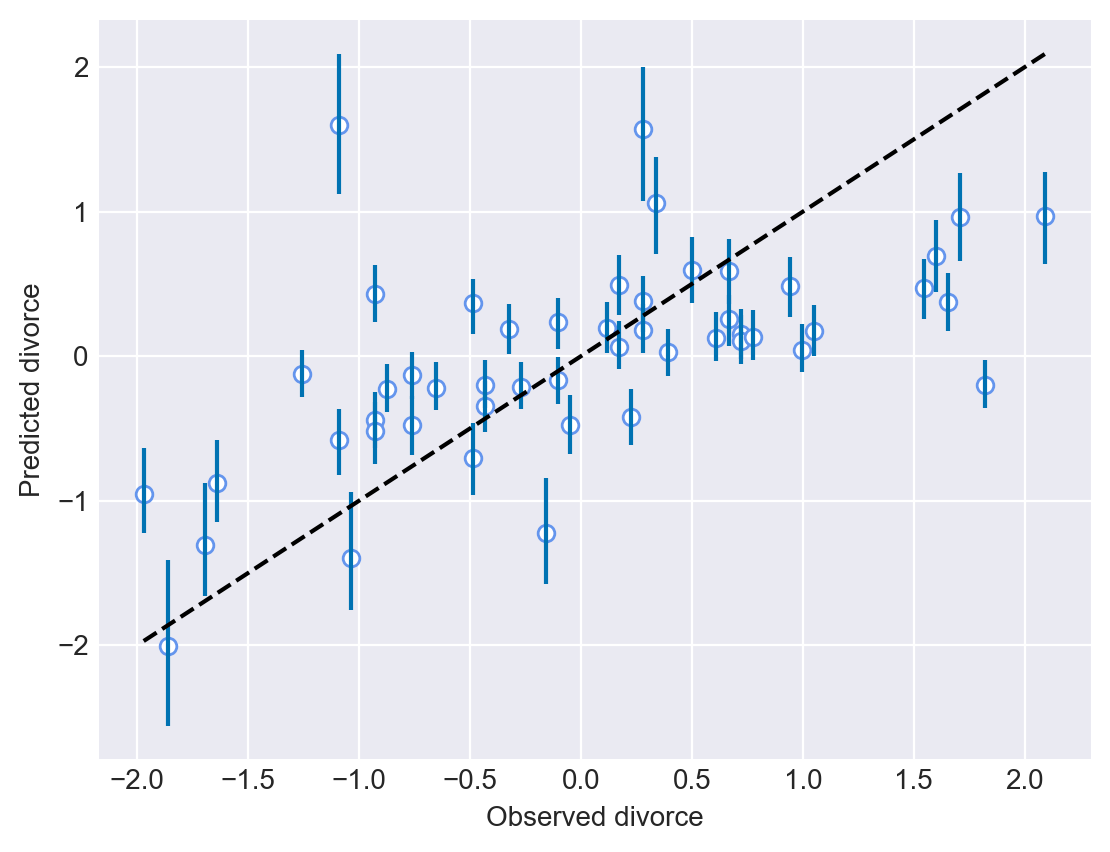

In [279]:
m5_4_idx = np.argsort(d.D)

plt.scatter(d.D, D_sim, edgecolors = 'cornflowerblue', facecolors = 'white');
plt.errorbar(d.D, D_sim, yerr=np.abs(mu_means - mu_PI.T), fmt = 'none')
plt.plot([d.D.min(), d.D.max()], [d.D.min(), d.D.max()], linestyle='dashed', color='black')
plt.xlabel('Observed divorce')
plt.ylabel('Predicted divorce')



#### Code 5.17

In [ ]:
#Its really annoying to try to label scatter plots in pyplot quite honestly


#### Code 5.18

In [ ]:
n = 100
x_real = stats.norm.rvs(0, 1, n)
x_spur = stats.norm.rvs(x_real, 1, n)
y = stats.norm.rvs(x_real, 1, n)

data = {'y': y,
        'x_real': x_real,
        'x_spur': x_spur,
        }

d = pd.DataFrame(data)

with pm.Model() as m_5_18:
    a = pm.Normal('a', 0, 1)
    b1 = pm.Normal('b1', 0, 1)
    b2 = pm.Normal('b2', 0, 1)
    sigma = pm.Exponential('sigma', 1)

    mu = pm.Deterministic('mu', a + b1 * d.x_spur + b2 * d.x_real)

    likelihood = pm.Normal('likelihood', mu = mu, sigma = sigma, observed = d.y)

    m_5_18_trace = pm.sample(100)

m_5_18_trace_means = m_5_18_trace.posterior.mu.sel(chain=1).values.mean(0)


m_5_18_trace_idx = np.argsort(m_5_18_trace_means)
x_real_sort = np.argsort(x_real)


_, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].scatter(d.x_real, d.y)
ax[0].set_title('X_real vs Y')
ax[0].set_ylabel('Y values')
ax[0].set_xlabel('X_real Values')


ax[1].scatter(d.x_spur, d.y)
ax[1].set_title('X_spur vs Y')
ax[1].set_ylabel('Y values')
ax[1].set_xlabel('X_spur Values')

az.plot_forest(m_5_18_trace, combined=True, var_names=['b1', 'b2'])


#### Code 5.19

In [ ]:
d = pd.read_csv('Data/WaffleDivorce.csv', sep=';')
d['A'] =( d.MedianAgeMarriage - d.MedianAgeMarriage.mean()) / d.MedianAgeMarriage.std()
d['D'] =( d.Divorce - d.Divorce.mean()) / d.Divorce.std()
d['M'] =( d.Marriage - d.Marriage.mean()) / d.Marriage.std()


with pm.Model() as m5_3A:
    ## A -> D <- M
    sigma = pm.Exponential('sigma', 1)
    a = pm.Normal('a', 0,.2)
    bM = pm.Normal('bM', 0, .5)
    bA = pm.Normal('bA', 0, .5)
    mu = pm.Deterministic('mu', a + (bM *d.M) + (bA * d.A))

    ## A -> M
    sigma_M = pm.Exponential('sigma_M', 1)
    aM = pm.Normal('aM', 0,.2)
    bAM = pm.Normal('bAM', 0, .5)
    mu_M = pm.Deterministic('mu_M', aM + (bAM *d.A))

    D = pm.Normal('D', mu = mu, sigma = sigma, observed = d.D)
    M = pm.Normal('M', mu = mu_M, sigma = sigma_M, observed = d.M)

    m5_3_a_trace = pm.sample(1000)

exclude_vars = ['mu_M', 'mu']
var_names = [name for name in m5_3_a_trace.posterior.keys() if name not in exclude_vars]

pm.summary(m5_3_a_trace, var_names=var_names)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a, bM, bA, sigma_M, aM, bAM]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


#### Code 5.20

In [ ]:
# Counterfactual sequence for A
A_seq = np.linspace(-2, 2, 30)


(30,)

#### Code 5.21

In [ ]:
# Extract posterior samples
a_posterior = m5_3_a_trace.posterior.a.values.flatten()
bM_posterior = m5_3_a_trace.posterior.bM.values.flatten()
bA_posterior = m5_3_a_trace.posterior.bA.values.flatten()
aM_posterior = m5_3_a_trace.posterior.aM.values.flatten()
bAM_posterior = m5_3_a_trace.posterior.bAM.values.flatten()

# Initialize arrays for counterfactual calculations
n_samples = len(a_posterior)
counterfactual_D = np.zeros((n_samples, len(A_seq)))
counterfactual_M = np.zeros((n_samples, len(A_seq)))

# Calculate counterfactuals
for i in range(n_samples):
    # M: Counterfactual for M
    counterfactual_M[i] = aM_posterior[i] + bAM_posterior[i] * A_seq
    
    # D: Counterfactual for D
    counterfactual_D[i] = (
        a_posterior[i]
        + bM_posterior[i] * counterfactual_M[i]
        + bA_posterior[i] * A_seq
    )

# Compute mean and credible intervals
mean_D = counterfactual_D.mean(axis=0)
hdi_D = az.hdi(counterfactual_D, hdi_prob= .89)

mean_M = counterfactual_M.mean(axis=0)
hdi_M = az.hdi(counterfactual_M, hdi_prob= .89)




/var/folders/v0/f2hcx8fs7_z5zrx8d8tr410r0000gn/T/ipykernel_20534/420135026.py:30: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_D = az.hdi(counterfactual_D, hdi_prob= .89)
/var/folders/v0/f2hcx8fs7_z5zrx8d8tr410r0000gn/T/ipykernel_20534/420135026.py:33: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_M = az.hdi(counterfactual_M, hdi_prob= .89)


#### Code 5.22

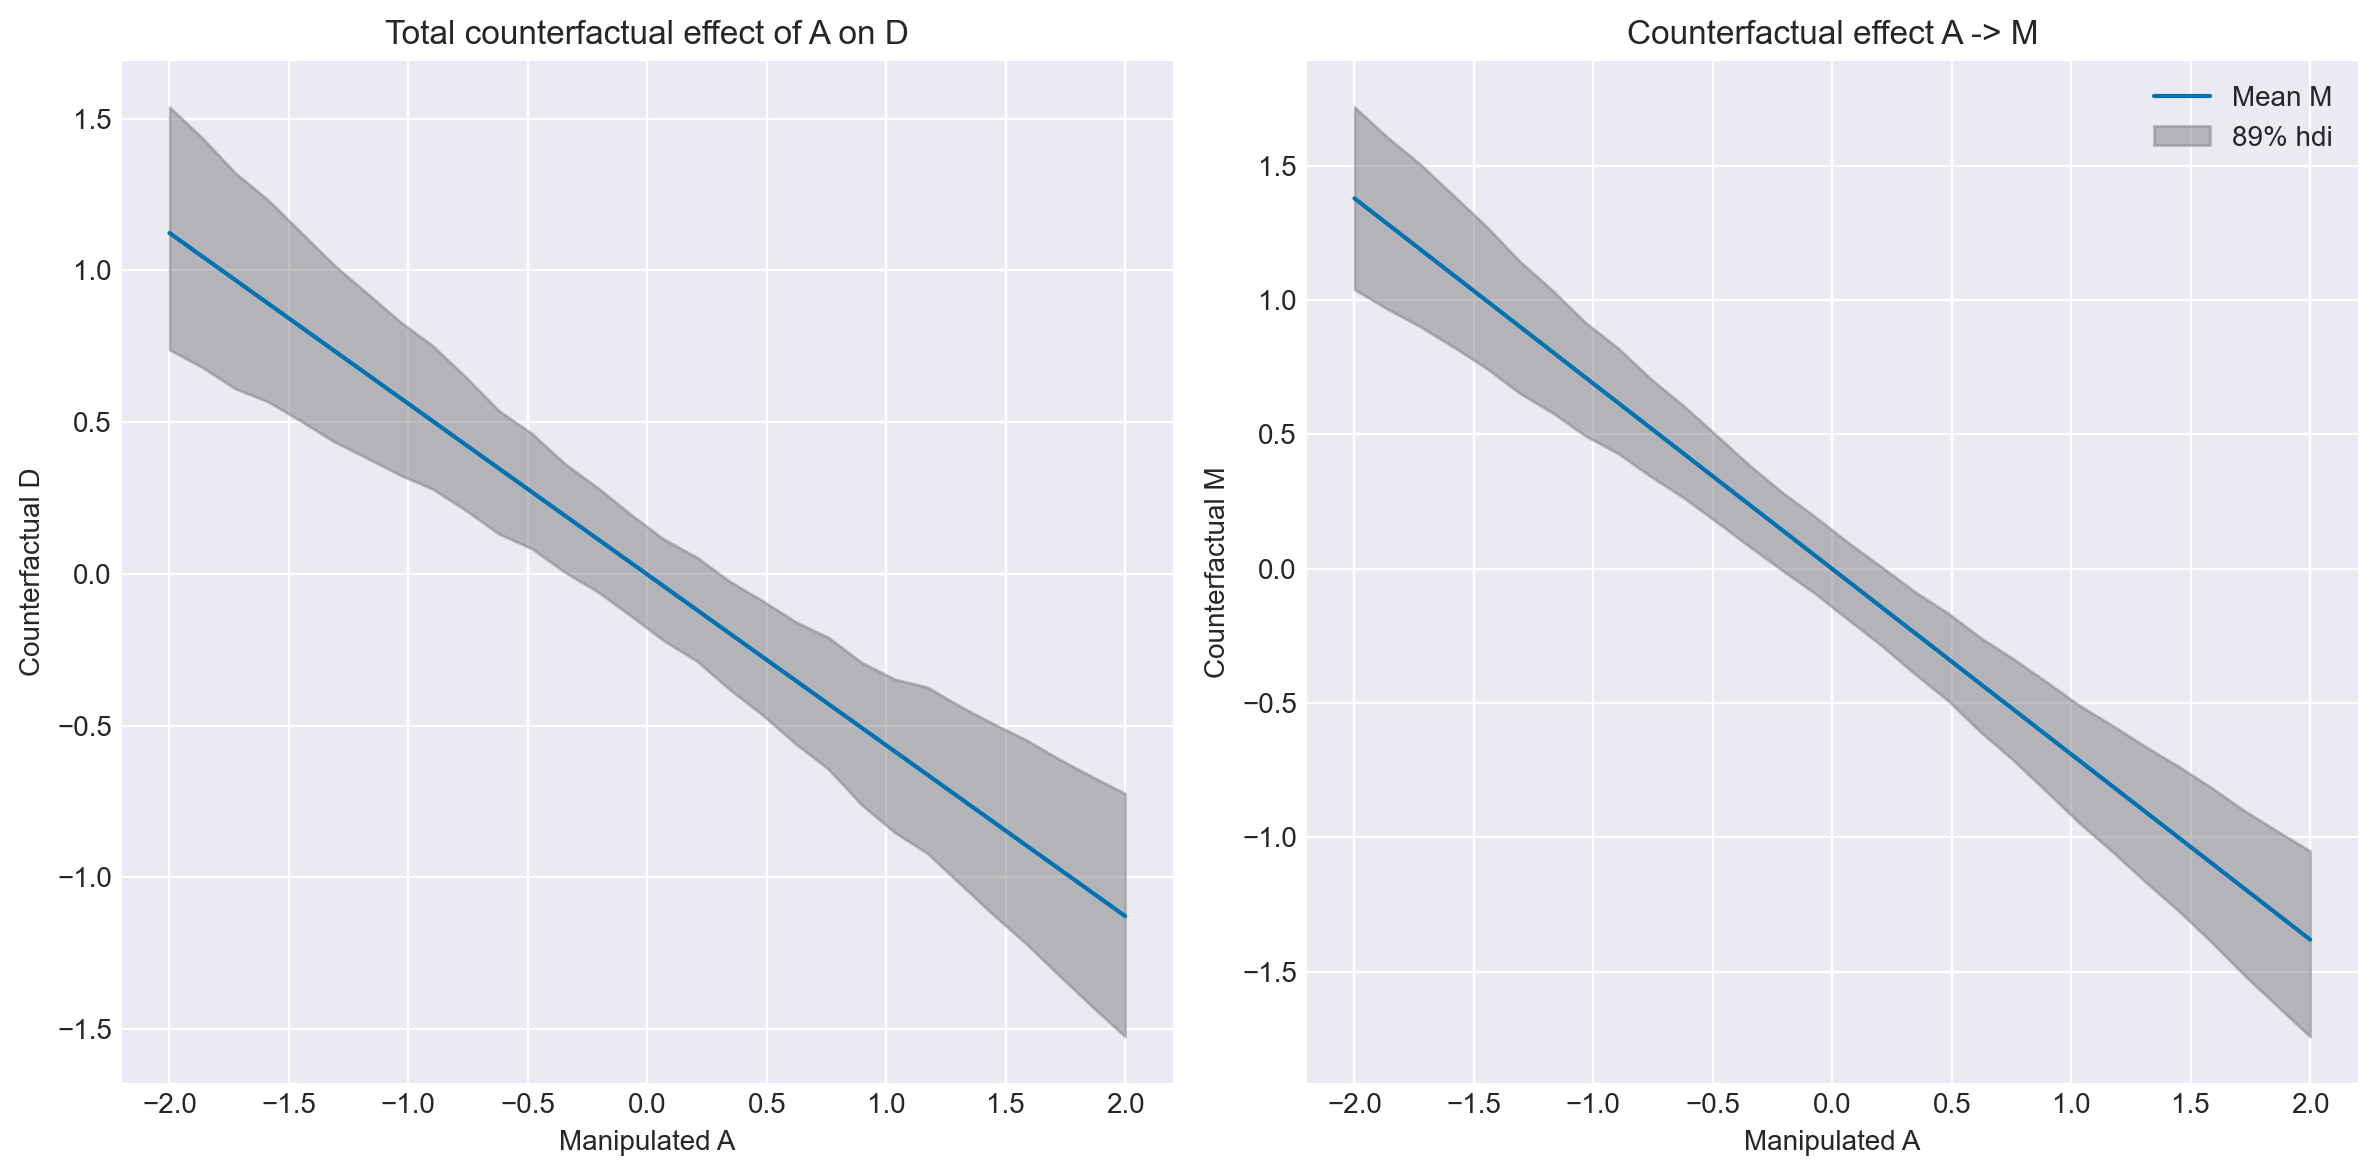

In [604]:
# Plot
plt.figure(figsize=(12, 6))

# Plot for D
plt.subplot(1, 2, 1)
plt.plot(A_seq, mean_D, label="Mean D")
plt.fill_between(A_seq, hdi_D[:,1],  hdi_D[:,0], color="gray", alpha=0.5, label="89% hdi")
plt.title("Total counterfactual effect of A on D")
plt.xlabel("Manipulated A")
plt.ylabel("Counterfactual D")

# Plot for M
plt.subplot(1, 2, 2)
plt.plot(A_seq, mean_M, label="Mean M")
plt.fill_between(A_seq, hdi_M[:,1],  hdi_M[:,0], color="gray", alpha=0.5, label="89% hdi")
plt.title("Counterfactual effect A -> M")
plt.xlabel("Manipulated A")
plt.ylabel("Counterfactual M")
plt.legend()

plt.tight_layout()
plt.show()

#### Code 5.23

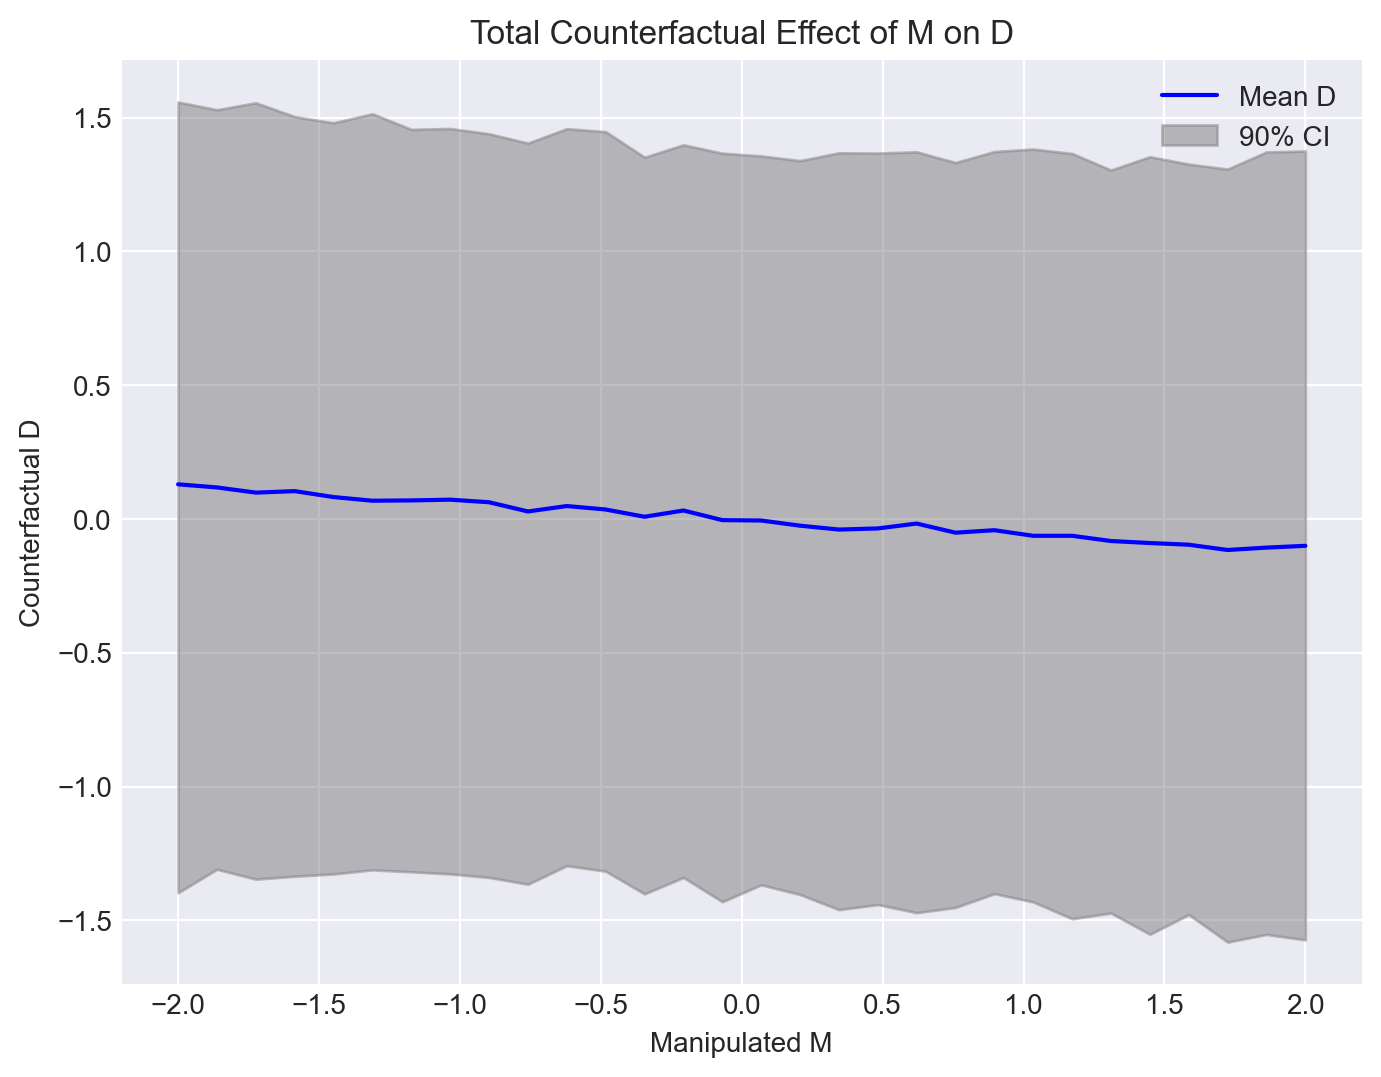

In [420]:
# Define the counterfactual data
M_seq = np.linspace(-2, 2, 30)  # Manipulated values for M
A_fixed = 0  # Hold A constant at 0

# Extract posterior samples from the saved model
posterior = m5_3_a_trace.posterior

# Extract parameter samples
a_samples = posterior['a'].values.flatten()
bM_samples = posterior['bM'].values.flatten()
bA_samples = posterior['bA'].values.flatten()
sigma_samples = posterior['sigma'].values.flatten()

# Number of posterior samples and counterfactual points
n_samples = len(a_samples)
n_M = len(M_seq)

# Initialize array to store predictions
D_counterfactual = np.zeros((n_samples, n_M))

# Compute counterfactual predictions
for i, M in enumerate(M_seq):
    # For each posterior sample, compute the predicted D
    D_counterfactual[:, i] = (
        a_samples +
        bM_samples * M +
        bA_samples * A_fixed +
        np.random.normal(0, sigma_samples)
    )

# Compute mean and credible intervals
D_mean = D_counterfactual.mean(axis=0)
D_lower = np.percentile(D_counterfactual, 5, axis=0)  # 5% CI
D_upper = np.percentile(D_counterfactual, 95, axis=0)  # 95% CI

# Plot the counterfactual predictions
plt.figure(figsize=(8, 6))
plt.plot(M_seq, D_mean, label="Mean D", color="blue")
plt.fill_between(M_seq, D_lower, D_upper, color="gray", alpha=0.5, label="90% CI")
plt.xlabel("Manipulated M")
plt.ylabel("Counterfactual D")
plt.title("Total Counterfactual Effect of M on D")
plt.legend()
plt.show()

In [318]:
with pm.Model() as m_5_18:
    a = pm.Normal('a', 0, 1)
    b1 = pm.Normal('b1', 0, 1)
    b2 = pm.Normal('b2', 0, 1)
    sigma = pm.Exponential('sigma', 1)

    mu = pm.Deterministic('mu', a + b1 * d.x_spur + b2 * d.x_real)

    likelihood = pm.Normal('likelihood', mu = mu, sigma = sigma, observed = d.y)

    m_5_18_trace = pm.sample(1000)

m_5_18_trace_means = m_5_18_trace.posterior.mu.sel(chain=1).values.mean(0)


m_5_18_trace_idx = np.argsort(m_5_18_trace_means)
m_5_18_trace_means.shape

m_5_18_trace_idx = np.argsort(m_5_18_trace_means)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b1, b2, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


#### Code 5.27

In [423]:
d = pd.read_csv('Data/milk.csv', sep=';')

d.columns

Index(['clade', 'species', 'kcal.per.g', 'perc.fat', 'perc.protein',
       'perc.lactose', 'mass', 'neocortex.perc'],
      dtype='object')

#### Code 5.28

In [425]:
d['K'] = (d['kcal.per.g'] - d['kcal.per.g'].mean()) - d['kcal.per.g'].std()
d['N'] = (d['neocortex.perc'] - d['neocortex.perc'].mean()) - d['neocortex.perc'].std()
d['M'] = (d['mass'] - d['mass'].mean()) - d['mass'].std()

d.head(5)

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,K,N,M
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.313126,-18.384494,-37.547366
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,-0.293126,NaN,-37.407366
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,-0.343126,NaN,-36.987366
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,-0.323126,NaN,-37.877366
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,-0.203126,NaN,-37.307366


#### Code 5.29

In [ ]:
with pm.Model() as m5_5_draft:
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Normal('a', mu = 0, sigma = 1)
    bN = pm.Normal('bN', mu = 0, sigma= 1)
    mu = pm.Deterministic('mu', alpha + bN * d.N)

    likelihood = pm.Normal('likelihood', mu = mu, sigma = sigma, observed = d.K )

    m5_5_draft_trace = pm.sample(1000)

#### Code 5.30

In [ ]:
d['neocortex.perc']

#### Code 5.31

In [591]:
dcc = d.dropna()

dcc['K'] = (dcc['kcal.per.g'] - dcc['kcal.per.g'].mean()) / dcc['kcal.per.g'].std()
dcc['N'] = (dcc['neocortex.perc'] - dcc['neocortex.perc'].mean()) / dcc['neocortex.perc'].std()
dcc['M'] = (dcc['mass'] - dcc['mass'].mean()) / dcc['mass'].std()
dcc['lM'] = np.log(dcc.mass)

dcc['lM_std'] =( dcc.lM - dcc.lM.mean()) / dcc.lM.std()
dcc

/var/folders/v0/f2hcx8fs7_z5zrx8d8tr410r0000gn/T/ipykernel_20534/1393429545.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcc['K'] = (dcc['kcal.per.g'] - dcc['kcal.per.g'].mean()) / dcc['kcal.per.g'].std()
/var/folders/v0/f2hcx8fs7_z5zrx8d8tr410r0000gn/T/ipykernel_20534/1393429545.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcc['N'] = (dcc['neocortex.perc'] - dcc['neocortex.perc'].mean()) / dcc['neocortex.perc'].std()
/var/folders/v0/f2hcx8fs7_z5zrx8d8tr410r0000gn/T/ipykernel_20534/1393429545.

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,K,N,M,lM,lM_std
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.969623,-2.080196,-0.622824,0.667829,-0.430154
5,New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54,-1.085298,-0.508641,-0.482889,1.658228,0.082211
6,New World Monkey,A palliata,0.56,29.66,23.46,46.88,5.37,64.54,-0.564763,-0.508641,-0.477801,1.680828,0.093902
7,New World Monkey,Cebus apella,0.89,53.41,15.80,30.79,2.51,67.64,1.343864,0.010742,-0.599078,0.920283,-0.299552
9,New World Monkey,S sciureus,0.92,50.58,22.33,27.09,0.68,68.85,1.517376,0.213470,-0.676678,-0.385662,-0.975160
10,New World Monkey,Cebuella pygmaea,0.80,41.35,20.85,37.80,0.12,58.85,0.823329,-1.461962,-0.700425,-2.120264,-1.872525
11,New World Monkey,Callimico goeldii,0.46,3.93,25.30,70.77,0.47,61.69,-1.143135,-0.986139,-0.685583,-0.755023,-1.166241
12,New World Monkey,Callithrix jacchus,0.71,38.38,20.09,41.53,0.32,60.32,0.302795,-1.215673,-0.691944,-1.139434,-1.365110
15,Old World Monkey,Miopithecus talpoin,0.68,40.15,18.08,41.77,1.55,69.97,0.129283,0.401118,-0.639786,0.438255,-0.548921
17,Old World Monkey,M mulatta,0.97,55.51,13.17,31.32,3.24,70.41,1.806561,0.474837,-0.568122,1.175573,-0.167482


#### Code 5.32

In [541]:
with pm.Model() as m5_5_draft:
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Normal('a', mu = 0, sigma = 1)
    bN = pm.Normal('bN', mu = 0, sigma= 1)
    mu = pm.Deterministic('mu', alpha + bN * dcc.N)

    likelihood = pm.Normal('likelihood', mu = mu, sigma = sigma, observed = dcc.K )

    m5_5_draft_trace = pm.sample(1000)
    m5_5_draft_prior_trace = pm.sample_prior_predictive(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a, bN]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [a, bN, likelihood, sigma]


#### Code 5.33

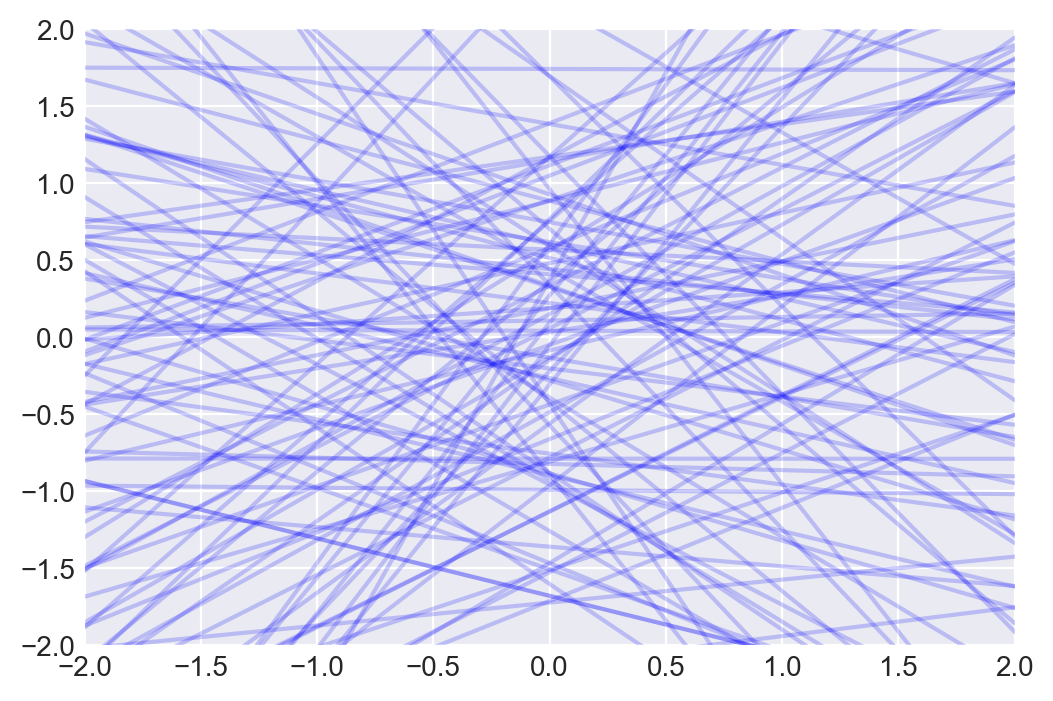

In [533]:
prior_df = m5_5_draft_prior_trace.prior.to_dataframe().reset_index()
x_range = np.linspace(-2,2, 100)

# Iterate over a subset of prior samples
plt.figure(figsize=(6, 4))
for _, column in prior_df.sample(len(x_range)).iterrows():  # Use a subset for clarity
    # Compute y-values for the prior predictive line
    y = column['a'] + column['bN'] * (x_range)
    plt.plot(x_range, y, color='blue', alpha=0.2)
    plt.xlim(-2,2)
    plt.ylim(-2,2)


#### Code 5.34

In [555]:
with pm.Model() as m5_5:
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Normal('a', mu = 0, sigma = .2)
    bN = pm.Normal('bN', mu = 0, sigma = .5)
    mu = pm.Deterministic('mu', alpha + bN * dcc.N)

    K = pm.Normal('K', mu = mu, sigma = sigma, observed = dcc.K)

    m5_5_prior_trace = pm.sample_prior_predictive(1000)
    m5_5_trace = pm.sample(1000)



Sampling: [K, a, bN, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a, bN]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


#### Code 5.35

In [556]:
pm.summary(m5_5_trace, var_names = ['a','bN','sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.000,0.153,-0.294,0.283,0.002,0.003,5459.0,3066.0,1.0
bN,0.120,0.229,-0.302,0.558,0.003,0.003,4894.0,2807.0,1.0
sigma,1.037,0.190,0.705,1.380,0.003,0.002,4149.0,2862.0,1.0


#### Figure 5.8

In [ ]:
prior_df_5_5 = m5_5_prior_trace.prior.to_dataframe().reset_index()
prior_df_draft = m5_5_draft_prior_trace.prior.to_dataframe().reset_index()

x_seq = np.linspace(-2,2, 100)

_, ax = plt.subplots(1, 2, figsize=(6, 4))

for _, column in prior_df_draft.sample(len(x_seq)).iterrows():  # Use a subset for clarity
    y = column['a'] + column['bN'] * (x_seq)
    ax[0].plot(x_range, y, color='grey', alpha=0.4)
    ax[0].set_title('a ~ Normal(0 ,1) \n bN ~ Normal(0, 1)')
    ax[0].set_xlabel('neocortex percent (std)')
    ax[0].set_xlim(-2,2)
    ax[0].set_ylabel('kilocal per g (std)')
    ax[0].set_ylim(-2,2)

for _, column in prior_df_5_5.sample(len(x_seq)).iterrows():  # Use a subset for clarity
    y = column['a'] + column['bN'] * (x_seq)
    ax[1].plot(x_range, y, color='grey', alpha=0.4)
    ax[1].set_title('a ~ Normal(0 , 0.2) \n bN ~ Normal(0, 0.5)')
    ax[1].set_xlabel('neocortex percent (std)')
    ax[1].set_xlim(-2,2)
    ax[1].set_ylabel('kilocal per g (std)')
    ax[1].set_ylim(-2,2)

#### Code 5.36

/var/folders/v0/f2hcx8fs7_z5zrx8d8tr410r0000gn/T/ipykernel_20534/900627774.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_PI = az.hdi(mu, hdi_prob = .89);


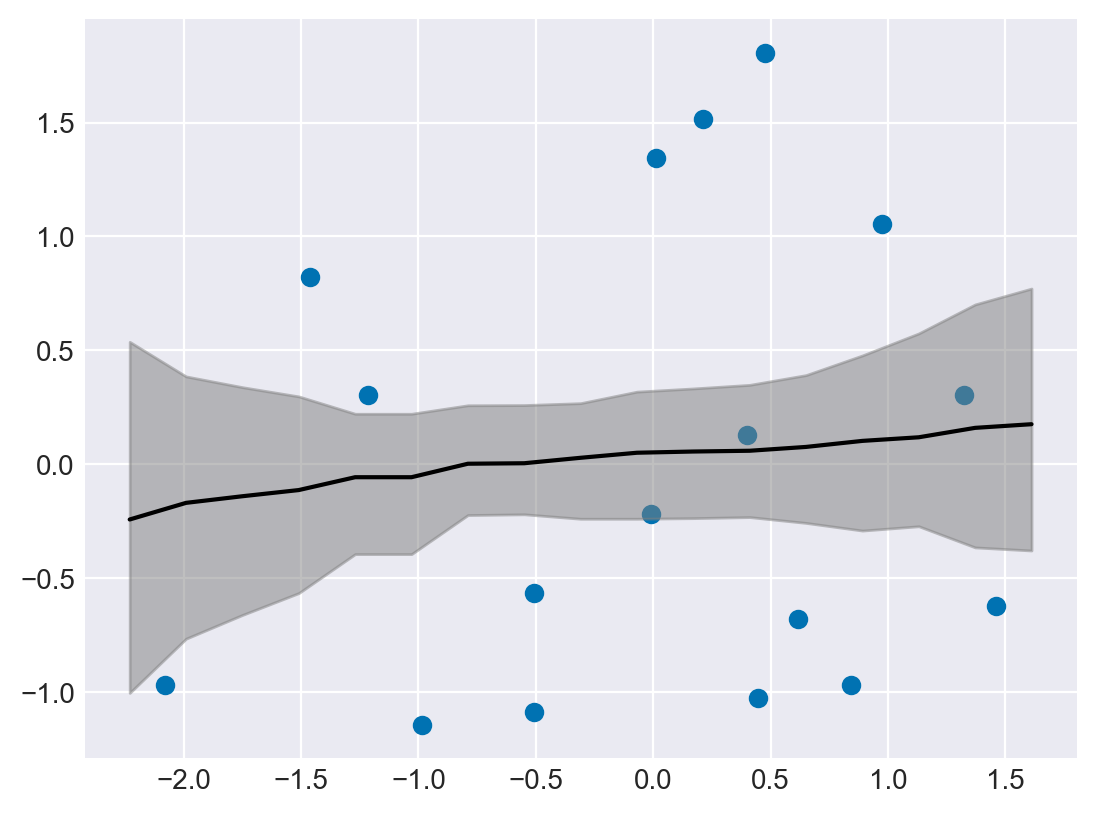

In [586]:
x_seq = np.linspace(dcc.N.min() - 0.15, dcc.N.max()+0.15,17)
n_idx = np.argsort(dcc.N)
mu = m5_5_trace.posterior.mu.sel(chain = 1).values
mu_idx = np.argsort(mu)
mu_mean = mu.mean(0)
mu_PI = az.hdi(mu, hdi_prob = .89);

plt.scatter(dcc.N, dcc.K);
plt.plot(x_seq, mu_mean[n_idx],color ='black');
plt.fill_between(x_seq, mu_PI[:,1][n_idx], mu_PI[:,0][n_idx], color ='grey', alpha = .5);

#### Code 5.37

Sampling: [K, a, bM, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a, bM]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
/var/folders/v0/f2hcx8fs7_z5zrx8d8tr410r0000gn/T/ipykernel_20534/2595919833.py:19: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_PI = az.hdi(mu, hdi_prob = .89);


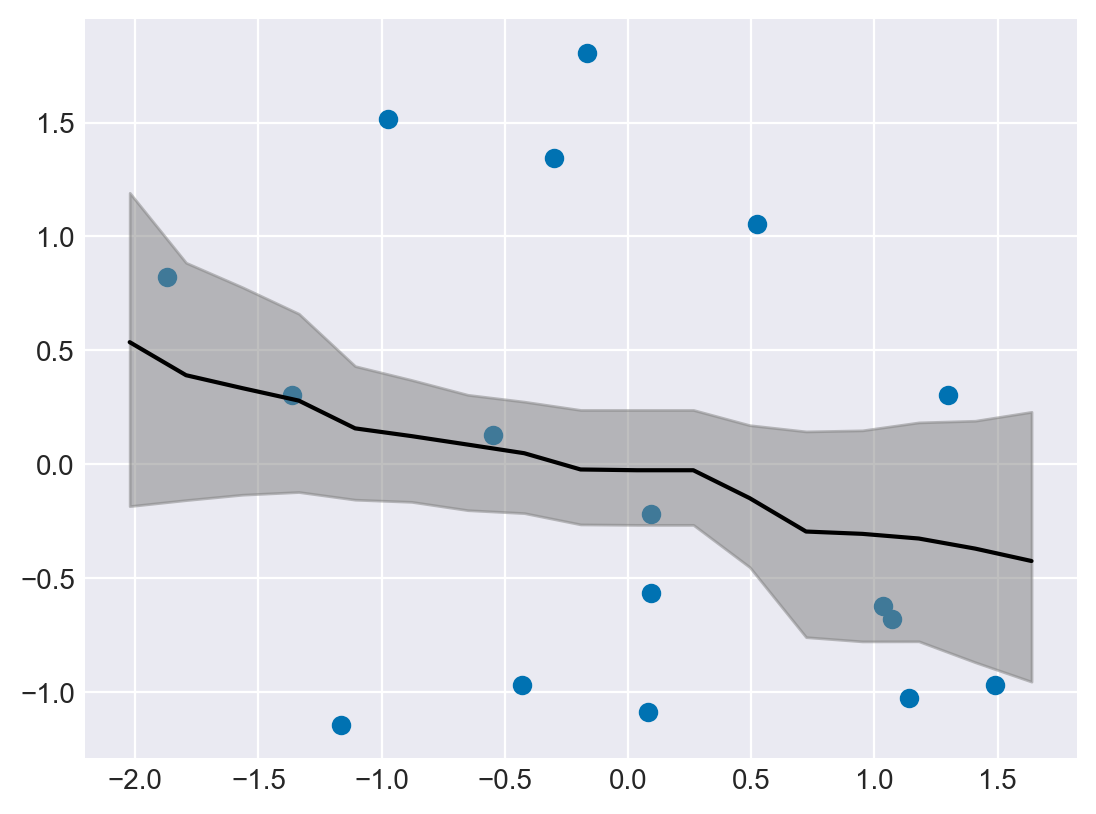

In [594]:
with pm.Model() as m5_6:
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Normal('a', mu = 0, sigma = .2)
    bM = pm.Normal('bM', mu = 0, sigma = .5)
    mu = pm.Deterministic('mu', alpha + bM * dcc.lM_std)

    K = pm.Normal('K', mu = mu, sigma = sigma, observed = dcc.K)

    m5_6_prior_trace = pm.sample_prior_predictive(1000)
    m5_6_trace = pm.sample(1000)

pm.summary(m5_6_trace, var_names = ['a','bM','sigma'])

x_seq = np.linspace(dcc.lM_std.min() - 0.15, dcc.lM_std.max()+0.15,17)
n_idx = np.argsort(dcc.lM_std)
mu = m5_6_trace.posterior.mu.sel(chain = 1).values
mu_idx = np.argsort(mu)
mu_mean = mu.mean(0)
mu_PI = az.hdi(mu, hdi_prob = .89);

plt.scatter(dcc.lM_std, dcc.K);
plt.plot(x_seq, mu_mean[n_idx],color ='black');
plt.fill_between(x_seq, mu_PI[:,1][n_idx], mu_PI[:,0][n_idx], color ='grey', alpha = .5);

#### Code 5.38

In [596]:
with pm.Model() as m5_7:
    alpha = pm.Normal('a', mu = 0, sigma = .2)
    bN = pm.Normal('bN', mu = 0, sigma = .5)
    bM = pm.Normal('bM', mu = 0, sigma = .5)

    sigma = pm.Exponential('sigma', 1)

    K = pm.Deterministic('K', alpha + bN * dcc.N + bM * dcc.lM_std)

    likelihood = pm.Normal('likelihood', mu = K, sigma = sigma, observed = dcc.K)

    m5_7_trace = pm.sample(1000)
    m5_7_prior_trace = pm.sample_prior_predictive(1000)

pm.summary(m5_7_trace, var_names = ['a','bM', 'bN', 'sigma'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bN, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [a, bM, bN, likelihood, sigma]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.000,0.138,-0.265,0.250,0.002,0.002,3130.0,2838.0,1.0
bM,-0.668,0.263,-1.177,-0.192,0.005,0.004,2387.0,2225.0,1.0
bN,0.565,0.262,0.064,1.035,0.005,0.004,2292.0,2346.0,1.0
sigma,0.813,0.170,0.541,1.137,0.003,0.002,2463.0,2347.0,1.0


#### Code 5.39

In [ ]:
az.plot_forest([m5_7_trace, m5_6_trace, m5_5_trace],
     var_names = ['bM', 'bN'], 
     combined=True,
     model_names = ['m5_7','m5_6','m5_5']);


#### Code 5.4

In [ ]:
xseq = np.linspace(dcc.N.min() - 0.15, dcc.N.max() + 0.15, 17)

# Extract posterior samples
a_posterior = m5_7_trace.posterior.a.values.flatten()
bM_posterior = m5_7_trace.posterior.bM.values.flatten()
bN_posterior = m5_7_trace.posterior.bN.values.flatten()


# Initialize arrays for counterfactual calculations
n_samples = len(a_posterior)
counterfactual_M = np.zeros((n_samples, len(A_seq)))
counterfactual_N = np.zeros((n_samples, len(A_seq)))

n_values = np.zeros_like(xseq)
# Calculate counterfactuals
for i in range(n_samples):
    # M: Counterfactual for M
    #counterfactual_M[i] = aM_posterior[i] + bAM_posterior[i] * A_seq
    
    # D: Counterfactual for D
    counterfactual_M[i] = (
        a_posterior[i]
        + bN_posterior[i] * n_values
        + bM_posterior[i] * xseq
    )
    counterfactual_N[i] = (
        a_posterior[i]
        + bN_posterior[i] * xseq
        + bM_posterior[i] * n_values
    )



mean_M = counterfactual_M.mean(axis=0)
hdi_M = az.hdi(counterfactual_M, hdi_prob= .89)

mean_N = counterfactual_N.mean(axis=0)
hdi_N = az.hdi(counterfactual_N, hdi_prob= .89)



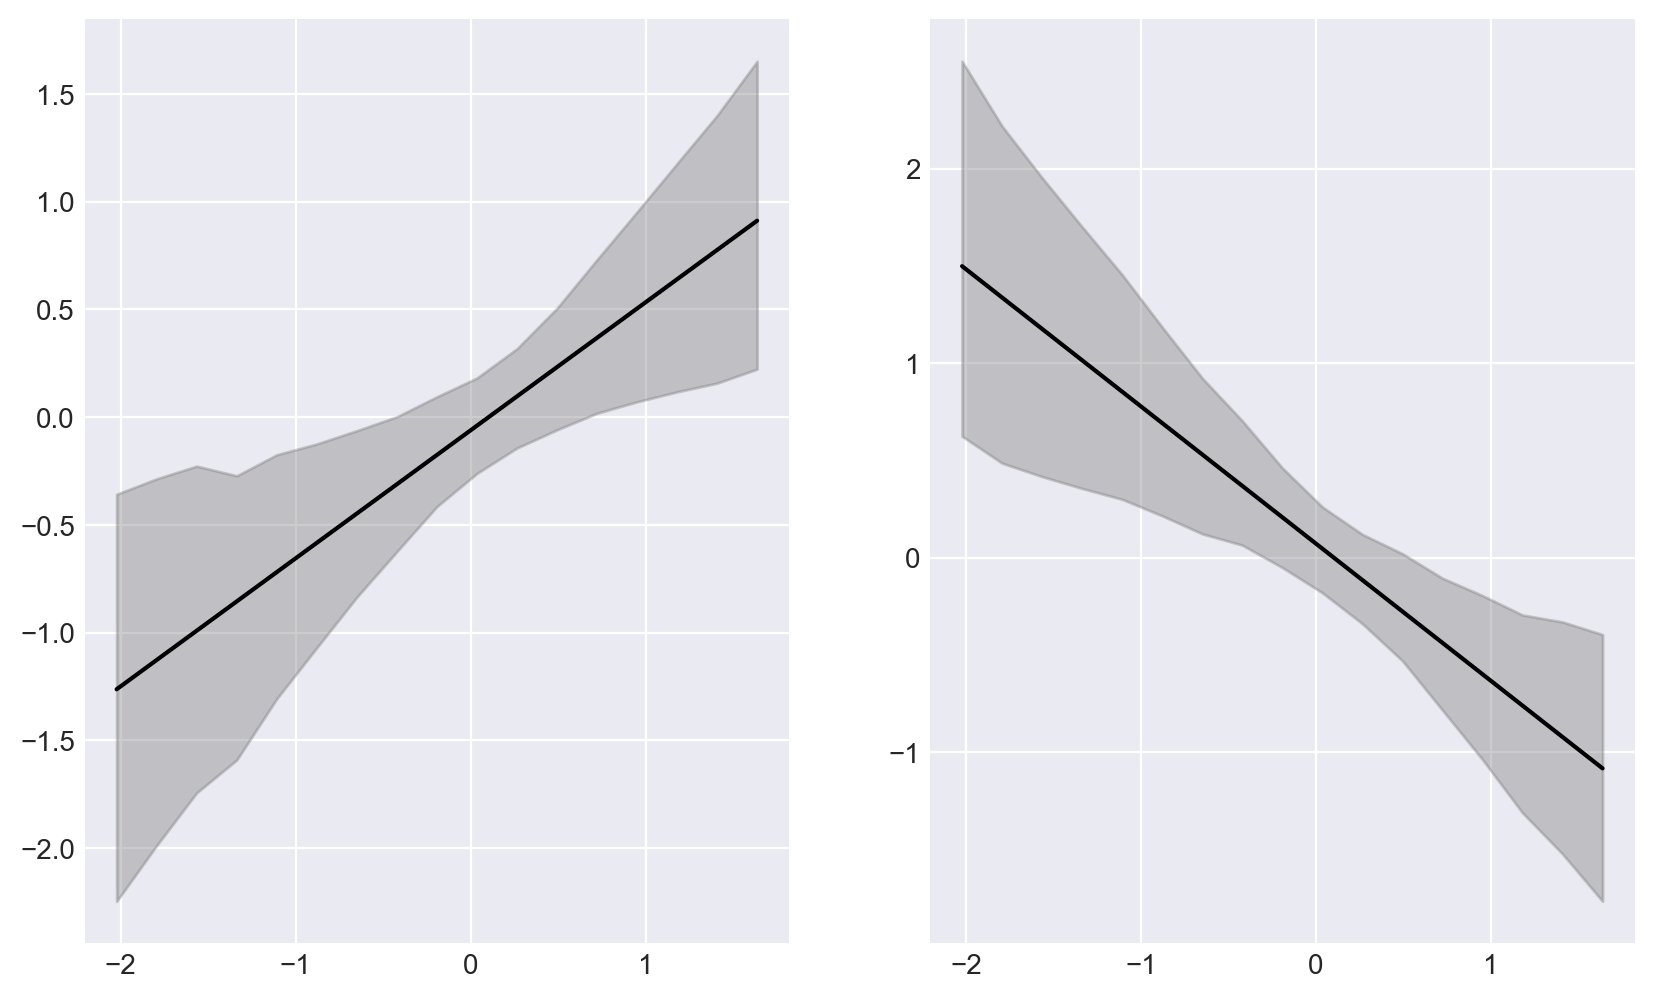

In [643]:
_, ax = plt.subplots(1,2, figsize=(10,6))
ax[1].plot(x_seq, mean_M, color = 'black')
ax[1].fill_between(x_seq, hdi_M[:,1], hdi_M[:,0], color = 'grey', alpha = .4)
ax[0].plot(x_seq, mean_N, color = 'black')
ax[0].fill_between(x_seq, hdi_N[:,1], hdi_N[:,0], color = 'grey', alpha = .4)

#### Code 5.41 (Overthinking)

In [ ]:
# M -> K <- N
# M -> N

n = 100
M = stats.norm.rvs(0, 2, n)
N = stats.norm.rvs(M, 2, n)
K = stats.norm.rvs(N-M, 2, n)

d_sim = pd.DataFrame({'K': K,
                      'N': N,
                      'M': M})

#### Code 5.42

In [ ]:
# M -> K <- N
# N -> M

n = 100
N = stats.norm.rvs(0, 2, n)
M = stats.norm.rvs(N, 2, n)
K = stats.norm.rvs(N-M, 2, n)

d_sim_2 = pd.DataFrame({'K': K,
                      'N': N,
                      'M': M})

# M -> K <- N
# M <- U -> N

n = 100
U = stats.norm.rvs(0, 2, n)
N = stats.norm.rvs(U, 2, n)
M = stats.norm.rvs(U, 2, n)
K = stats.norm.rvs(N-M, 2, n)

d_sim_3= pd.DataFrame({'K': K,
                      'N': N,
                      'M': M})

#### Code 5.43

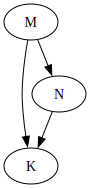

[]

In [ ]:
dag5_7_1 = CausalGraphicalModel(
    nodes=["K", "M", "N"],
    edges=[("M", "N"), ("M", "K"), ("N","K")],
)

dag5_7_2 = CausalGraphicalModel(
    nodes=["K", "M", "N"],
    edges=[("M", "N"), ("M", "K"), ("N","K")],
)


# List conditional independencies implied by the DAG
display(dag5_7_1.draw())
dag5_7_1.get_all_independence_relationships() #{A} can be read as 'conditional on A.'  If there is no conditional dependency you'll get a []

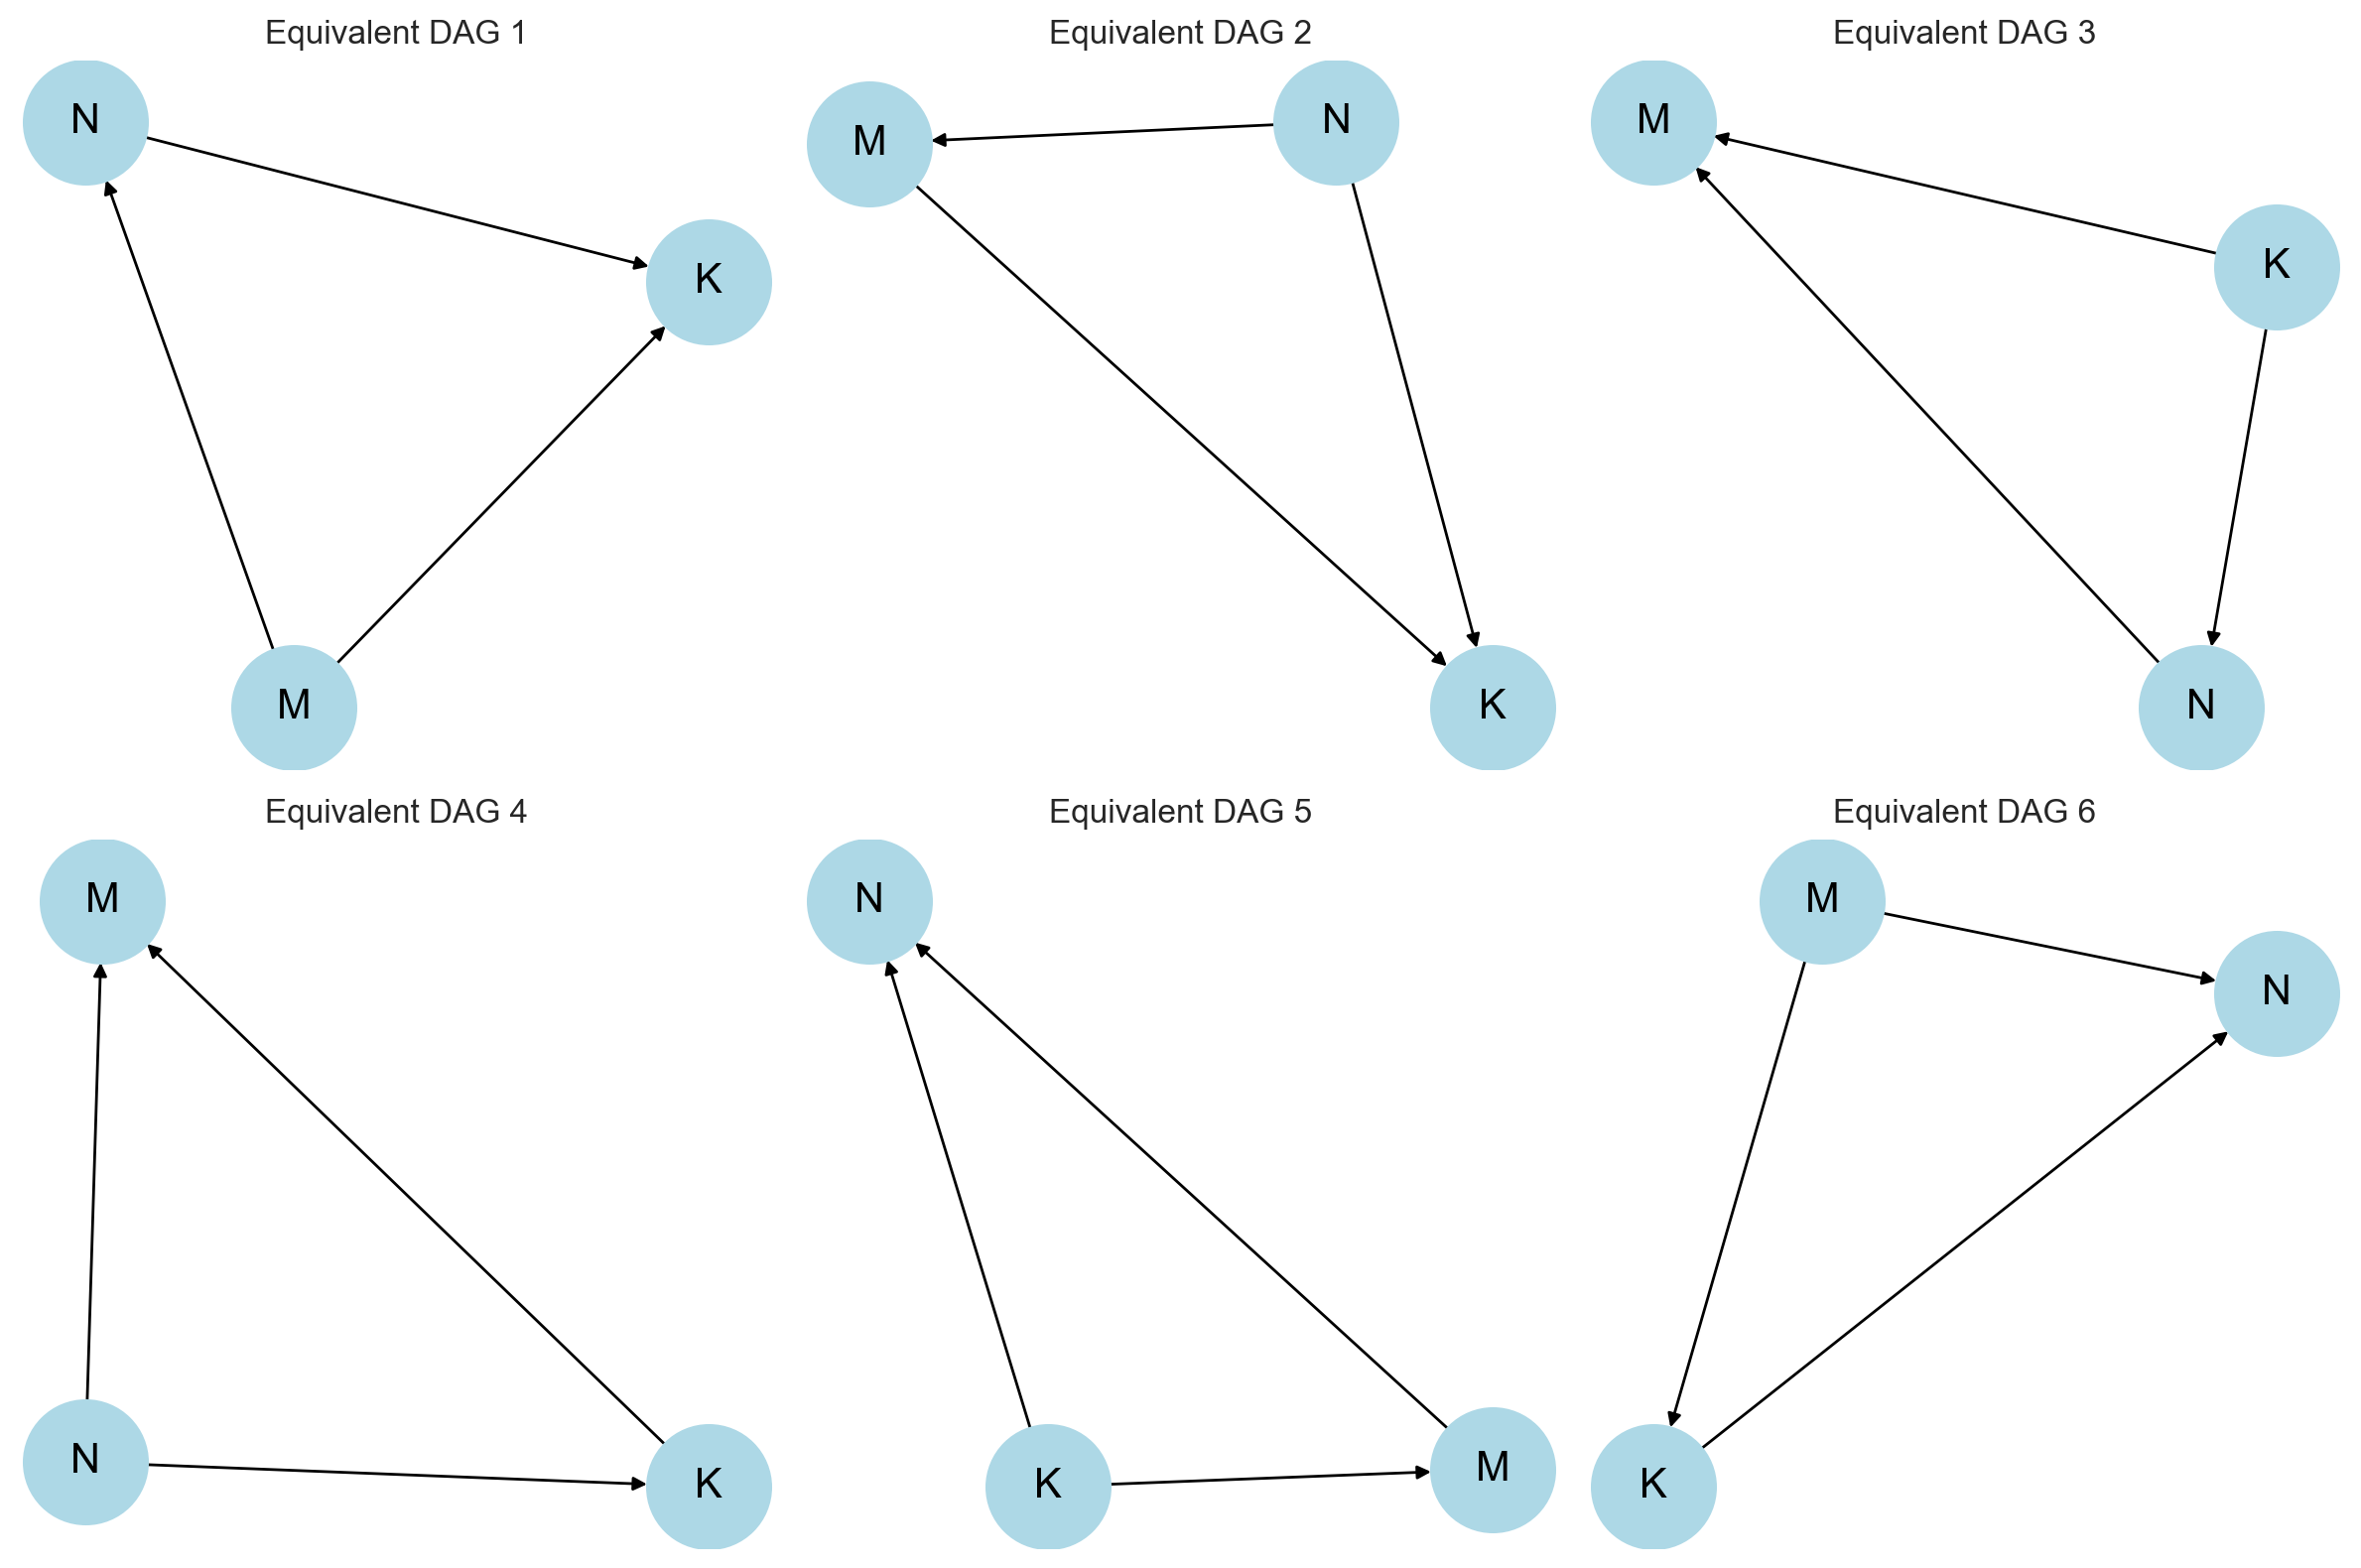

In [650]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import permutations

def generate_equivalent_dags(edges):
    """
    Generate all equivalent DAGs by permuting parent-child relationships while preserving
    the Markov equivalence structure.
    """
    # Define the base nodes and structure
    base_nodes = set(node for edge in edges for node in edge)
    dags = []

    # Iterate over all permutations of the nodes
    for perm in permutations(base_nodes):
        perm_map = {old: new for old, new in zip(base_nodes, perm)}
        perm_edges = [(perm_map[u], perm_map[v]) for u, v in edges]
        
        # Check if this structure is already represented
        new_dag = nx.DiGraph()
        new_dag.add_edges_from(perm_edges)
        if new_dag not in dags:
            dags.append(new_dag)

    return dags

# Base DAG edges
base_edges = [('M', 'K'), ('N', 'K'), ('M', 'N')]

# Generate equivalent DAGs
equivalent_dags = generate_equivalent_dags(base_edges)

# Plot all equivalent DAGs
plt.figure(figsize=(12, 8))
for i, dag in enumerate(equivalent_dags, start=1):
    plt.subplot(2, 3, i)
    nx.draw(dag, with_labels=True, node_color='lightblue', node_size=2000, font_size=15)
    plt.title(f"Equivalent DAG {i}")

plt.tight_layout()
plt.show()


#### Code 5.44

In [651]:
d = pd.read_csv('Data/Howell1.csv', sep=';')

d.head(3)

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0


#### Code 5.45

In [657]:
mu_female = stats.norm.rvs(178,  20, 1000)
mu_male = stats.norm.rvs(178,  20, 1000) + stats.norm.rvs(0,10, 1000)
f_m_mus = pd.DataFrame({'mu_female': mu_female,
                        'mu_male': mu_male})

f_m_mus.describe()

,mu_female,mu_male
count,1000.000000,1000.000000
mean,177.260225,177.857314
std,19.620046,22.206317
min,120.114410,112.560241
25%,163.731268,162.109019
50%,177.284272,178.135675
75%,190.871059,193.785930
max,230.189200,240.833560


In [665]:
d['sex'] = np.where(d['male'] == 0, 1, 2)

d.sex[:10]

array([2, 1, 1, 2, 1, 2, 1, 2, 1, 2])

#### Code 5.47

In [673]:
with pm.Model() as m_5_8:
    sigma = pm.Uniform('sigma', 0, 50)
    a = pm.Normal('a', mu = 178, sigma = 20, shape = 2)
    mu = pm.Deterministic('mu', a[d.male])

    h = pm.Normal('h', mu = mu, sigma = sigma, observed = d.height)

    m_5_8_trace = pm.sample()

pm.summary(m_5_8_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],134.903,1.600,131.925,137.870,0.022,0.015,5547.0,3025.0,1.0
a[1],142.536,1.706,139.244,145.570,0.021,0.015,6393.0,2821.0,1.0
mu[0],142.536,1.706,139.244,145.570,0.021,0.015,6393.0,2821.0,1.0
mu[1],134.903,1.600,131.925,137.870,0.022,0.015,5547.0,3025.0,1.0
mu[2],134.903,1.600,131.925,137.870,0.022,0.015,5547.0,3025.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[540],142.536,1.706,139.244,145.570,0.021,0.015,6393.0,2821.0,1.0
mu[541],134.903,1.600,131.925,137.870,0.022,0.015,5547.0,3025.0,1.0
mu[542],142.536,1.706,139.244,145.570,0.021,0.015,6393.0,2821.0,1.0
mu[543],142.536,1.706,139.244,145.570,0.021,0.015,6393.0,2821.0,1.0


#### Code 5.48

In [699]:
m_5_8_a0 = m_5_8_trace.posterior.sel(a_dim_0 = 0).a.values.flatten()
m_5_8_a1 = m_5_8_trace.posterior.sel(a_dim_0 = 1).a.values.flatten()

mean_diff =np.mean(m_5_8_a0 - m_5_8_a1)

mean_diff
# m_5_8_df['diff_fm'] = m_5_
# m_5_8_df.head(10)
# #display( m_5_8_df.head(10), m_5_8_df.describe())

-7.632719877976901

#### Code 5.49

In [700]:
d = pd.read_csv('Data/milk.csv', sep=';')
d.head(2)

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN


#### Code 5.50

In [726]:
d['clade_id'], clade_unique = pd.factorize(d.clade)

d.head(10)


,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,clade_id,K
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,0,-0.940041
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,0,-0.816126
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,0,-1.125913
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,0,-1.001998
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,0,-0.258511
5,New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54,1,-1.063955
6,New World Monkey,A palliata,0.56,29.66,23.46,46.88,5.37,64.54,1,-0.506340
7,New World Monkey,Cebus apella,0.89,53.41,15.80,30.79,2.51,67.64,1,1.538249
8,New World Monkey,Saimiri boliviensis,0.91,46.08,23.34,30.58,0.71,NaN,1,1.662163
9,New World Monkey,S sciureus,0.92,50.58,22.33,27.09,0.68,68.85,1,1.724120


#### Code 5.51

In [727]:
d['K'] = (d['kcal.per.g'] - d['kcal.per.g'].mean()) / d['kcal.per.g'].std()


## To implement the labeling feature we need to build a coords dictionary
coords = {'clade': clade_unique}

with pm.Model(coords = coords) as m5_9:
    alpha = pm.Normal('a', 0, .5, dims = 'clade')
    mu = pm.Deterministic('mu', alpha[d.clade_id])
    sigma=  pm.Exponential('sigma', 1)

    K = pm.Normal('K', mu = mu, sigma = sigma, observed = d.K)

    m5_9_trace = pm.sample()




Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

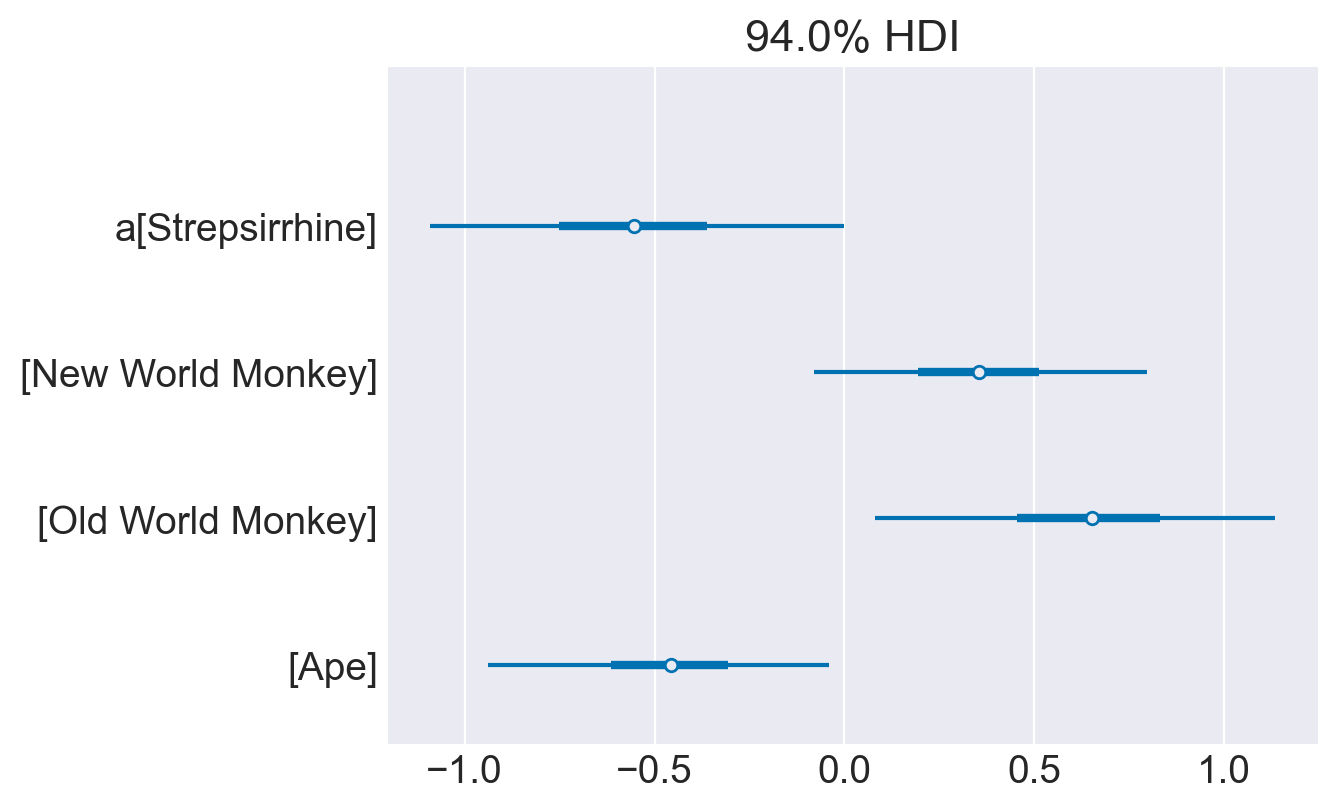

In [ ]:
az.plot_forest(m5_9_trace, var_names='a', combined = True)

# Note that the data is the same but the order is slighly different because they weren't organized alphabetically

#### Code 5.52

In [ ]:
np.random.seed(63)
d['house'] = rand_array = np.random.randint(0, 4, size=d.shape[0])

#### Code 5.53

In [749]:
coords['house'] = ['Gryffindor', 'Hufflepuff', 'Ravenclaw', 'Slytherin']


with pm.Model(coords = coords) as m5_10:
    sigma = pm.Exponential('sigma', 1)
    h = pm.Normal('h', mu = 0, sigma = .5, dims = 'clade')
    a = pm.Normal('a', mu = 0, sigma = .5, dims = 'house')
    mu = pm.Deterministic('mu', a[d.clade_id] + h[d.house])
    K = pm.Normal('K', mu = mu, sigma = sigma, observed = d.K)

    m5_10_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, h, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


---
#### C3E1

**Question**: 


Which of the linear models below are multiple linear regressions?

(1) $ \mu_i = \alpha + \beta \chi_i $

(2) $ \mu_i = \beta_x \chi_i + \beta_z  \zeta_i$

(3) $ \mu_i = \alpha + \beta ( \chi_i - \zeta_i ) $

(4) $ \mu_i = a + \beta_x \chi_i + \beta_z \zeta_i $

---
<details>
<summary>Answer</summary>

(2) and (4)

</details>

---
#### C5E2

**Question**: 

Write down a multiple regression to evaluate the claim: 

_Animal diversity is linearly related to latitude, but only after controlling for plant diversity. You just need to write down the model definition._

---
<details>
<summary>Answer</summary>

$ AD = Normal(\mu, \sigma) $

$ \sigma = Exponential(1) $

$ \mu = \alpha + \beta_p PlantDiv + \beta_l Lat $

$ \beta_p = Normal(0,1) $

$ \beta_l = Normal(0,1) $

</details>

---
#### C5E3

**Question**: 

Write down a multiple regression to evaluate the claim: 

_Neither amount of funding nor size of laboratory is by itself a good predictor of time to PhD degree; but together these variables are both positively associated with time to degree. Write down the model definition and indicate which side of zero each slope parameter should be on._


---
<details>
<summary>Answer</summary>

$ Time to PhD = Normal(\mu, \sigma) $

$ \sigma = Exponential(1) $

$ \mu = \alpha + \beta_f Funding - \beta_l LabSize $

$ \beta_f = Normal(0,1) $ *Positive Slope

$ \beta_l = Normal(0,1) $ *Negative Slope

</details>

---
#### C5E4

**Question**: 

Suppose you have a single categorical predictor with 4 levels (unique values), labeled A, B, C and D. Let Ai be an indicator variable that is 1 where case i is in category A. Also suppose Bi, Ci, and Di for the other categories. Now which of the following linear models are inferentially equivalent ways to include the categorical variable in a regression? Models are inferentially equivalent when it’s possible to compute one posterior distribution from the posterior distribution of another model.

(1) $ \mu_i = \alpha + \beta_A A_i +  \beta_B B_i +  \beta_D D_i $

(2) $ \mu_i = \alpha + \beta_A A_i +  \beta_B B_i +  \beta_C C_i +  \beta_D D_i $

(3) $ \mu_i = \alpha + \beta_B B_i +  \beta_C C_i +  \beta _D D_i $

(4) $ \mu_i = \alpha_A A_i + \alpha_B B_i +  \alpha_C C_i +  \alpha_D D_i $

(5) $ \mu_i = \alpha_A(1-B_i - C_i - D_i) + \alpha_B B_i +  \alpha_C C_i +  \alpha_D D_i $

---
<details>
<summary>Answer</summary>

The models that work (are valid and inferentially equivalent) are:

Model (1): Leaves out 
𝐶
C as the reference group.

Model (3): Leaves out 
𝐴
A as the reference group.

Model (5): A re-arranged version of 
𝐴
A as the reference group.

Models (2) and (4) don’t work unless you make special fixes.


</details>


---
#### C5M1

**Question**: 

Invent your own example of a spurious correlation. An outcome variable should be correlated with both predictor variables. But when both predictors are entered in the same model, the correlation between the outcome and one of the predictors should mostly vanish (or at least be greatly reduced).

---
<details>
<summary>Answer</summary>

n = 50
p1 = stats.norm.rvs(0,1,n)
p2 = stats.norm.rvs(p1,1,n)
outcome = stats.norm.rvs(p1, 1, n)

</details>

In [ ]:
n = 50
p1 = stats.norm.rvs(0,1,n)
p2 = stats.norm.rvs(-p1,1,n)
outcome = stats.norm.rvs(p1+p2, 1, n)

df = pd.DataFrame({'p1': p1,
                   'p2': p2,
                   'outcome': outcome,})

display(df.head(10))

'''
with pm.Model() as m1_p1:
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Normal('alpha', mu = 0, sigma = 1)
    beta  = pm.Normal('beta', mu = 0, sigma = 1)
    mu = pm.Deterministic('mu', alpha + beta * df.p1)

    outcome = pm.Normal('outcome', mu = mu, sigma = sigma, observed = df.outcome)

    m1_p1_trace = pm.sample()

display(pm.summary(m1_p1_trace, var_names = ['alpha', 'beta', 'sigma']))

with pm.Model() as m1_p2:
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Normal('alpha', mu = 0, sigma = 1)
    beta  = pm.Normal('beta', mu = 0, sigma = 1)
    mu = pm.Deterministic('mu', alpha + beta * df.p2)

    outcome = pm.Normal('outcome', mu = mu, sigma = sigma, observed = df.outcome)

    m1_p2_trace = pm.sample()

display(pm.summary(m1_p2_trace, var_names = ['alpha', 'beta', 'sigma']))

with pm.Model() as m1_p1_p2:
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Normal('alpha', mu = 0, sigma = 1)
    beta  = pm.Normal('beta', mu = 0, sigma = 1, shape = 2)
    mu = pm.Deterministic('mu', alpha + beta[0] * df.p1 + beta[1] * df.p2)

    outcome = pm.Normal('outcome', mu = mu, sigma = sigma, observed = df.outcome)

    m1_p1_p2_trace = pm.sample()

display(pm.summary(m1_p1_p2_trace, var_names = ['alpha', 'beta', 'sigma']))
'''

---
#### C5M2

**Question**: 

Invent your own example of a masked relationship. An outcome variable should be correlated with both predictor variables, but in opposite directions. And the two predictor variables should be correlated with one another.

---
<details>
<summary>Answer</summary>

```
n = 50
p1 = stats.norm.rvs(0,1,n)
p2 = stats.norm.rvs(0,1,n)
outcome = stats.norm.rvs(p1-p2, 1, n)


df = pd.DataFrame({'p1': p1,
                   'p2': p2,
                   'outcome': outcome,})

with pm.Model() as m1_p1:
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Normal('alpha', mu = 0, sigma = 1)
    beta  = pm.Normal('beta', mu = 0, sigma = 1)
    mu = pm.Deterministic('mu', alpha + beta * df.p1)

    outcome = pm.Normal('outcome', mu = mu, sigma = sigma, observed = df.outcome)

    m1_p1_trace = pm.sample()

display(pm.summary(m1_p1_trace, var_names = ['alpha', 'beta', 'sigma']))

with pm.Model() as m1_p2:
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Normal('alpha', mu = 0, sigma = 1)
    beta  = pm.Normal('beta', mu = 0, sigma = 1)
    mu = pm.Deterministic('mu', alpha + beta * df.p2)

    outcome = pm.Normal('outcome', mu = mu, sigma = sigma, observed = df.outcome)

    m1_p2_trace = pm.sample()

display(pm.summary(m1_p2_trace, var_names = ['alpha', 'beta', 'sigma']))

with pm.Model() as m1_p1_p2:
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Normal('alpha', mu = 0, sigma = 1)
    beta  = pm.Normal('beta', mu = 0, sigma = 1, shape = 2)
    mu = pm.Deterministic('mu', alpha + beta[0] * df.p1 + beta[1] * df.p2)

    outcome = pm.Normal('outcome', mu = mu, sigma = sigma, observed = df.outcome)

    m1_p1_p2_trace = pm.sample()

display(pm.summary(m1_p1_p2_trace, var_names = ['alpha', 'beta', 'sigma']))
```

</details>

---
#### C5M2

**Question**: 

It is sometimes observed that the best predictor of fire risk is the presence of firefighters— States and localities with many firefighters also have more fires. Presumably firefighters do not cause fires. Nevertheless, this is not a spurious correlation. Instead fires cause firefighters. Consider the same reversal of causal inference in the context of the divorce and marriage data. How might a high divorce rate cause a higher marriage rate? Can you think of a way to evaluate this relationship, using multiple regression?

---
<details>
<summary>Answer</summary>

So there are two parts to this question:

(1) How might a high divorce rate cause a higher marriage rate?

Without the knowledge that marriage is _intended_ to only happen once, it's easy to imagine why a high divorce rate might cause a higher marriage rate. A state where people are only getting married once on average compared to a state where people are getting married 12 times on average, there's a higher likelihood of an individual being married at any given time.

(2) Can you think of a way to evaluate this relationship, using multiple regression?

In order to evaluate this I think the best way to capture it is through "re-marry rate." Essentially, you'd have:

$MarriageRate = \alpha + \beta_d DivorceRate + \beta_r RemarryRate $

where $ RemarryRate $ is whether or not a person has been remarried.  You may want to parse out "widow(ers)" from the sample as they may have a higher tendency to remarry than divorcees.

</details>


---
#### C5M4

**Question**: 

In the divorce data, States with high numbers of Mormons (members of The Church of Jesus Christ of Latter-day Saints, LDS) have much lower divorce rates than the regression models expected. Find a list of LDS population by State and use those numbers as a predictor variable, predicting divorce rate using marriage rate, median age at marriage, and percent LDS population (possibly standardized). You may want to consider transformations of the raw percent LDS variable.

---
<details>
<summary>Answer</summary>

```
d = pd.read_csv('Data/WaffleDivorce.csv', sep=';')
lds = [0.0077, 0.0453, 0.0610, 0.0104, 0.0194, 0.0270, 0.0044, 0.0057, 0.0041, 0.0075, 
            0.0082, 0.0520, 0.2623, 0.0045, 0.0067, 0.0090, 0.0130, 0.0079, 0.0064, 0.0082, 
            0.0072, 0.0040, 0.0045, 0.0059, 0.0073, 0.0116, 0.0480, 0.0130, 0.0065, 0.0037, 
            0.0333, 0.0041, 0.0084, 0.0149, 0.0053, 0.0122, 0.0372, 0.0040, 0.0039, 0.0081, 
            0.0122, 0.0076, 0.0125, 0.6739, 0.0074, 0.0113, 0.0390, 0.0093, 0.0046, 0.1161]

log_lds = np.log(lds)
d['LDS'] = log_lds
d['L'] = (d['LDS'] - d['LDS'].mean()) / d['LDS'].std()
d['A'] = (d['MedianAgeMarriage'] - d['MedianAgeMarriage'].mean()) / d['MedianAgeMarriage'].std()
d['M'] = (d['Marriage'] - d['Marriage'].mean()) / d['Marriage'].std()
d['D'] = (d['Divorce'] - d['Divorce'].mean()) / d['Divorce'].std()


with pm.Model() as m_lds:
    sigma = pm.Exponential('sigma', .5)
    alpha = pm.Normal('a', mu = 0, sigma = .3)
    b_L = pm.Normal('L', mu = 0, sigma = .3)
    b_A = pm.Normal('A', mu = 0, sigma = .3)
    b_M = pm.Normal('M', mu = 0, sigma = .3)
    mu = pm.Deterministic('mu', alpha + b_L*d.L + b_A*d.A + b_M*d.M)

    likelihood = pm.Normal('likelihood', mu = mu, sigma = sigma, observed = d.D)

    prior_trace = pm.sample_prior_predictive(1000)
    trace = pm.sample()


prior_seq = np.linspace(-2, 2, 50)

prior_df = prior_trace.prior.to_dataframe().reset_index()

for i, r in prior_df.sample(50).iterrows():
    priors = r.a + (r.A * prior_seq) + (r.L * prior_seq) + (r.M * prior_seq)
    plt.plot(prior_seq, priors, color='black', alpha=0.2)


display(pm.summary(trace, var_names =['a', 'L', 'A', 'M', 'sigma'], hdi_prob = .89 ))
az.plot_forest(trace, combined = True, var_names =['a', 'L', 'A', 'M','sigma'], hdi_prob=.89)
```


</details>

---
#### C5M5

**Question**: 

One way to reason through multiple causation hypotheses is to imagine detailed mechanisms through which predictor variables may influence outcomes. For example, it is sometimes argued that the price of gasoline (predictor variable) is positively associated with lower obesity rates (outcome variable). However, there are at least two important mechanisms by which the price of gas could reduce obesity. First, it could lead to less driving and therefore more exercise. Second, it could lead to less driving, which leads to less eating out, which leads to less consumption of huge restaurant meals. Can you outline one or more multiple regressions that address these two mechanisms? Assume you can have any predictor data you need.

---
<details>
<summary>Answer</summary>

First we'll decide what we'll be measuring for our predictor data.  Assuming they are all standardized on a z-score basis:

$ stpm = Steps Taken Per Month $

$ mopm = Meals Out Per Month $

$ gpm = Gas Price Monthly AVG$

$ aorm =  Obesity Rate Monthly AVG$

$ \mu_i = \alpha + \beta_S S_i + \beta_M M_i + \beta_G G_i + \beta_A A_i $

</details>

---
#### Hard Questions

**Question**: 

All three exercises below use the same data, `foxes` The urban fox (Vulpes vulpes) is a successful exploiter of human habitat. Since urban foxes move in packs and defend territories, data on habitat quality and population density is also included. The data frame has five columns:

(1) `group`: Number of the social group the individual fox belongs to 

(2) `avgfood`: The average amount of food available in the territory 

(3) `groupsize`: The number of foxes in the social group

(4) `area`: Size of the territory

(5) `weight`: Body weight of the individual fox


---
#### C5H1

**Question**: 

Fit two bivariate Gaussian regressions:

(1) body weight as a linear function of territory size (area), and 

(2) body weight as a linear function of groupsize. 

Plot the results of these regressions, displaying the MAP regression line and the 95% interval of the mean. Is either variable important for predicting fox body weight?

---
<details>
<summary>Answer</summary>

```

with pm.Model() as m5h1:
    alpha = pm.Normal('a', mu = 0, sigma = 1)
    b_a = pm.Normal('ba', mu = 0, sigma = 1)
    mu = pm.Deterministic('mu', alpha + (b_a * d.area))
    sigma = pm.Exponential('sigma', 1)

    prior_trace = pm.sample_prior_predictive(1000)
    likelihood = pm.Normal('likelihoood', mu = mu, sigma = sigma, observed = d.weight)

    trace = pm.sample()

with pm.Model() as m5h2:
    alpha = pm.Normal('a', mu = 0, sigma = 1)
    b_a = pm.Normal('ba', mu = 0, sigma = 1)
    mu = pm.Deterministic('mu', alpha + (b_a * d.groupsize))
    sigma = pm.Exponential('sigma', 1)

    prior_trace_2 = pm.sample_prior_predictive(1000)
    likelihood = pm.Normal('likelihoood', mu = mu, sigma = sigma, observed = d.weight)

    trace_2 = pm.sample()


# Sort indices based on d.A


posteriors = trace.posterior.mu.sel(chain = 1).values

# Sort d.A and corresponding mean and HDI values
idx = np.argsort(d.area)
mean = posteriors.mean(0)  # Apply sorting to mean
mean_hdi = az.hdi(posteriors, hdi_prob=0.95)  # Compute HDI without sorting

_, ax= plt.subplots(1,2, figsize = (12,6))

ax[0].scatter(d.area, d.weight, label="Data");
ax[0].plot(d.area[idx], mean[idx], color="black", label="Mean");
ax[0].fill_between(d.area[idx], mean_hdi[:, 0][idx], mean_hdi[:, 1][idx], color="grey", alpha=0.3, label="89% HDI");
ax[0].set_xlabel("Area");
ax[0].set_ylabel("Weight");


# Sort indices based on d.A
g_idx = np.argsort(d.groupsize)

g_posteriors = trace_2.posterior.mu.sel(chain = 1).values

# Sort d.A and corresponding mean and HDI values
g_mean = g_posteriors.mean(0)  # Apply sorting to mean
g_mean_hdi = az.hdi(g_posteriors, hdi_prob=0.95)  # Compute HDI without sorting

ax[1].scatter(d.groupsize, d.weight, label="Data");
ax[1].plot(d.groupsize[g_idx], g_mean[g_idx], color="black", label="Mean");
ax[1].fill_between(d.groupsize[g_idx], g_mean_hdi[:, 0][g_idx], g_mean_hdi[:, 1][g_idx], color="grey", alpha=0.3, label="95% HDI");
ax[1].set_xlabel("Group Size");
ax[1].set_ylabel("Weight");



```

</details>

---
#### C5H2

**Question**: 

Now fit a multiple linear regression with weight as the outcome and both `area` and `groupsize` as predictor variables. Plot the predictions of the model for each predictor, holding the other predictor constant at its mean. What does this model say about the importance of each variable? Why do you get different results than you got in the exercise just above?

---
<details>
<summary>Answer</summary>

```

with pm.Model() as m5h3:
    alpha = pm.Normal('a', mu = 0, sigma = 1)
    ba = pm.Normal('ba', mu = 0, sigma = 1)
    bg = pm.Normal('bg', mu = 0, sigma = 1)
    mu = pm.Deterministic('mu', alpha +  (ba * d.area) + (bg * d.groupsize))
    sigma = pm.Exponential('sigma', 1)

    prior_trace_3 = pm.sample_prior_predictive(1000)
    likelihood = pm.Normal('likelihoood', mu = mu, sigma = sigma, observed = d.weight)

    trace_3 = pm.sample()

# Extract posterior samples
a_posterior = trace_3.posterior.a.values.flatten()
ba_posterior = trace_3.posterior.ba.values.flatten()
bg_posterior = trace_3.posterior.bg.values.flatten()

# Define dummy sequences for counterfactuals
area_seq = np.linspace(1, 6, 1000)  # Vary area
groupsize_seq = np.linspace(1, 10, 1000)  # Vary groupsize

# Hold the other variable constant at its mean
area_mean = d['area'].mean()
groupsize_mean = d['groupsize'].mean()

# Initialize arrays for counterfactual calculations
n_samples = len(a_posterior)
counterfactual_area = np.zeros((n_samples, len(area_seq)))  # Varying area
counterfactual_groupsize = np.zeros((n_samples, len(groupsize_seq)))  # Varying groupsize

# Calculate counterfactuals
for i in range(n_samples):
    # Counterfactual for varying area (holding groupsize constant)
    counterfactual_area[i] = (
        a_posterior[i]
        + ba_posterior[i] * area_seq
        + bg_posterior[i] * groupsize_mean
    )
    
    # Counterfactual for varying groupsize (holding area constant)
    counterfactual_groupsize[i] = (
        a_posterior[i]
        + ba_posterior[i] * area_mean
        + bg_posterior[i] * groupsize_seq
    )

# Compute mean and credible intervals
mean_area = counterfactual_area.mean(axis=0)
hdi_area = az.hdi(counterfactual_area, hdi_prob=0.95)

mean_groupsize = counterfactual_groupsize.mean(axis=0)
hdi_groupsize = az.hdi(counterfactual_groupsize, hdi_prob=0.95)

# Plot counterfactual predictions for area
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1);
plt.plot(area_seq, mean_area, label='Mean Prediction', color='black');
plt.fill_between(area_seq, hdi_area[:, 0], hdi_area[:, 1], color='grey', alpha=0.2, label='89% HDI');
plt.xlim(1,6)
plt.xlabel('Area');
plt.ylabel('Weight');
plt.title('Counterfactual Predictions: Varying Area');
plt.legend()

# Plot counterfactual predictions for groupsize
plt.subplot(1, 2, 2);
plt.plot(groupsize_seq, mean_groupsize, label='Mean Prediction', color='black');
plt.fill_between(groupsize_seq, hdi_groupsize[:, 0], hdi_groupsize[:, 1], color='grey', alpha=0.2, label='89% HDI');
plt.xlim(2,8)
plt.xlabel('Group Size');
plt.ylabel('Weight');
plt.title('Counterfactual Predictions: Varying Group Size');
plt.legend()

plt.tight_layout()
plt.show()


```

</details>

---
#### C5H3

**Question**: 

Finally, consider the avgfood variable. Fit two more multiple regressions: 
(1) body weight as an additive function of avgfood and groupsize, and 

(2) body weight as an additive function of all three variables, avgfood and groupsize and area. 

Compare the results of these models to the previous models you’ve fit, in the first two exercises: 

    (a) Is avgfood or area a better predictor of body weight? If you had to choose one or the other to include in a model, which would it be? Support your assessment with any tables or plots you choose. 
    
    (b) When both avgfood or area are in the same model, their effects are reduced (closer to zero) and their standard errors are larger than when they are included in separate models. Can you explain this result?

---
<details>
<summary>Answer</summary>

(a)
This seems counterintuitive to me but based on the counterfactual plot I would use `Area`.  I've made a counterfactual plot based on the two and it pretty clearly shows a larger association on `Area` when you hold `AvgFood` constant.

(b)
This is likely a case of multicolinearity.  When both are included they are highly correlated (`d[['avgfood','area']].corr()`). So when both are included they heavily influence each other.

```

with pm.Model() as m5h6:
    alpha = pm.Normal('a', mu = 0, sigma = 1)
    ba = pm.Normal('ba', mu = 0, sigma = 1)
    bf = pm.Normal('bf', mu = 0, sigma = 1)
    mu = pm.Deterministic('mu', alpha + (ba * d.area) + (bf * d.avgfood))
    sigma = pm.Exponential('sigma', 1)

    prior_trace_3 = pm.sample_prior_predictive(1000)
    likelihood = pm.Normal('likelihoood', mu = mu, sigma = sigma, observed = d.weight)

    trace_6 = pm.sample()

# Extract posterior samples
a_posterior = trace_6.posterior.a.values.flatten()
ba_posterior = trace_6.posterior.ba.values.flatten()
bf_posterior = trace_6.posterior.bf.values.flatten()

# Define dummy sequences for counterfactuals
area_seq = np.linspace(d.area.min(), d.area.max(), 1000)  # Vary area
avgfood_seq = np.linspace(d.avgfood.min(), d.avgfood.max(), 1000)  # Vary groupsize

# Hold the other variable constant at its mean
area_mean = d['area'].mean()
avgfood_mean = d['avgfood'].mean()

# Initialize arrays for counterfactual calculations
n_samples = len(a_posterior)
counterfactual_area = np.zeros((n_samples, len(area_seq)))  # Varying area
counterfactual_avgfood = np.zeros((n_samples, len(avgfood_seq)))  # Varying groupsize

# Calculate counterfactuals
for i in range(n_samples):
    # Counterfactual for varying area (holding groupsize constant)
    counterfactual_area[i] = (
        a_posterior[i]
        + ba_posterior[i] * area_seq
        + bf_posterior[i] * avgfood_mean
    )
    
    # Counterfactual for varying groupsize (holding area constant)
    counterfactual_avgfood[i] = (
        a_posterior[i]
        + ba_posterior[i] * area_mean
        + bf_posterior[i] * avgfood_seq
    )


# Compute mean and credible intervals
mean_area = counterfactual_area.mean(axis=0)
hdi_area = az.hdi(counterfactual_area, hdi_prob=0.95)

mean_avgfood = counterfactual_avgfood.mean(axis=0)
hdi_avgfood = az.hdi(counterfactual_avgfood, hdi_prob=0.95)


print(mean_avgfood.shape)
print(hdi_avgfood.shape)

# Plot counterfactual predictions for area
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1);
plt.plot(area_seq, mean_area, label='Mean Prediction', color='black');
plt.fill_between(area_seq, hdi_area[:, 0], hdi_area[:, 1], color='grey', alpha=0.2, label='89% HDI');
plt.xlim(d.area.min(),d.area.max())
plt.xlabel('Area');
plt.ylabel('Weight');
plt.title('Counterfactual Predictions: Varying Area');
plt.legend()

# Plot counterfactual predictions for groupsize
plt.subplot(1, 2, 2);
plt.plot(avgfood_seq, mean_avgfood, label='Mean Prediction', color='black');
plt.fill_between(avgfood_seq, hdi_avgfood[:, 0], hdi_avgfood[:, 1], color='grey', alpha=0.2, label='89% HDI');
plt.xlim(d.avgfood.min(),d.avgfood.max())
plt.xlabel('Avg Food');
plt.ylabel('Weight');
plt.title('Counterfactual Predictions: Varying Avg Food');
plt.legend()

plt.tight_layout()
plt.show()

```

</details>

In [365]:
d[['avgfood','area']].corr()

,avgfood,area
avgfood,1.000000,0.883104
area,0.883104,1.000000


In [342]:
# 

with pm.Model() as m5h1:
    alpha = pm.Normal('a', mu = 0, sigma = 1)
    ba = pm.Normal('ba', mu = 0, sigma = 1)
    mu = pm.Deterministic('mu', alpha + (ba * d.area))
    sigma = pm.Exponential('sigma', 1)

    prior_trace = pm.sample_prior_predictive(1000)
    likelihood = pm.Normal('likelihoood', mu = mu, sigma = sigma, observed = d.weight)

    trace = pm.sample()

with pm.Model() as m5h2:
    alpha = pm.Normal('a', mu = 0, sigma = 1)
    bg = pm.Normal('bg', mu = 0, sigma = 1)
    mu = pm.Deterministic('mu', alpha + (bg * d.groupsize))
    sigma = pm.Exponential('sigma', 1)

    prior_trace_2 = pm.sample_prior_predictive(1000)
    likelihood = pm.Normal('likelihoood', mu = mu, sigma = sigma, observed = d.weight)

    trace_2 = pm.sample()

with pm.Model() as m5h3:
    alpha = pm.Normal('a', mu = 0, sigma = 1)
    ba = pm.Normal('ba', mu = 0, sigma = 1)
    bg = pm.Normal('bg', mu = 0, sigma = 1)
    mu = pm.Deterministic('mu', alpha +  (ba * d.area) + (bg * d.groupsize))
    sigma = pm.Exponential('sigma', 1)

    prior_trace_3 = pm.sample_prior_predictive(1000)
    likelihood = pm.Normal('likelihoood', mu = mu, sigma = sigma, observed = d.weight)

    trace_3 = pm.sample()

with pm.Model() as m5h4:
    alpha = pm.Normal('a', mu = 0, sigma = 1)
    bg = pm.Normal('bg', mu = 0, sigma = 1)
    bf = pm.Normal('bf', mu = 0, sigma = 1)
    mu = pm.Deterministic('mu', alpha + (bg * d.groupsize) + (bf * d.avgfood))
    sigma = pm.Exponential('sigma', 1)

    prior_trace_3 = pm.sample_prior_predictive(1000)
    likelihood = pm.Normal('likelihoood', mu = mu, sigma = sigma, observed = d.weight)

    trace_4 = pm.sample()

with pm.Model() as m5h5:
    alpha = pm.Normal('a', mu = 0, sigma = 1)
    ba = pm.Normal('ba', mu = 0, sigma = 1)
    bg = pm.Normal('bg', mu = 0, sigma = 1)
    bf = pm.Normal('bf', mu = 0, sigma = 1)
    mu = pm.Deterministic('mu', alpha +  (ba * d.area) + (bg * d.groupsize) + (bf * d.avgfood))
    sigma = pm.Exponential('sigma', 1)

    prior_trace_3 = pm.sample_prior_predictive(1000)
    likelihood = pm.Normal('likelihoood', mu = mu, sigma = sigma, observed = d.weight)

    trace_5 = pm.sample()


'''



'''


Sampling: [a, ba, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, ba, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [a, bg, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bg, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [a, ba, bg, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, ba, bg, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [a, bf, bg, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bg, bf, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [a, ba, bf, bg, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, ba, bg, bf, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


'\n\n\n\n'

In [ ]:
with pm.Model() as m5h6:
    alpha = pm.Normal('a', mu = 0, sigma = 1)
    ba = pm.Normal('ba', mu = 0, sigma = 1)
    bf = pm.Normal('bf', mu = 0, sigma = 1)
    mu = pm.Deterministic('mu', alpha + (ba * d.area) + (bf * d.avgfood))
    sigma = pm.Exponential('sigma', 1)

    prior_trace_3 = pm.sample_prior_predictive(1000)
    likelihood = pm.Normal('likelihoood', mu = mu, sigma = sigma, observed = d.weight)

    trace_6 = pm.sample()

# Extract posterior samples
a_posterior = trace_6.posterior.a.values.flatten()
ba_posterior = trace_6.posterior.ba.values.flatten()
bf_posterior = trace_6.posterior.bf.values.flatten()

# Define dummy sequences for counterfactuals
area_seq = np.linspace(d.area.min(), d.area.max(), 1000)  # Vary area
avgfood_seq = np.linspace(d.avgfood.min(), d.avgfood.max(), 1000)  # Vary groupsize

# Hold the other variable constant at its mean
area_mean = d['area'].mean()
avgfood_mean = d['avgfood'].mean()

# Initialize arrays for counterfactual calculations
n_samples = len(a_posterior)
counterfactual_area = np.zeros((n_samples, len(area_seq)))  # Varying area
counterfactual_avgfood = np.zeros((n_samples, len(avgfood_seq)))  # Varying groupsize

# Calculate counterfactuals
for i in range(n_samples):
    # Counterfactual for varying area (holding groupsize constant)
    counterfactual_area[i] = (
        a_posterior[i]
        + ba_posterior[i] * area_seq
        + bf_posterior[i] * avgfood_mean
    )
    
    # Counterfactual for varying groupsize (holding area constant)
    counterfactual_avgfood[i] = (
        a_posterior[i]
        + ba_posterior[i] * area_mean
        + bf_posterior[i] * avgfood_seq
    )


# Compute mean and credible intervals
mean_area = counterfactual_area.mean(axis=0)
hdi_area = az.hdi(counterfactual_area, hdi_prob=0.95)

mean_avgfood = counterfactual_avgfood.mean(axis=0)
hdi_avgfood = az.hdi(counterfactual_avgfood, hdi_prob=0.95)


print(mean_avgfood.shape)
print(hdi_avgfood.shape)

# Plot counterfactual predictions for area
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1);
plt.plot(area_seq, mean_area, label='Mean Prediction', color='black');
plt.fill_between(area_seq, hdi_area[:, 0], hdi_area[:, 1], color='grey', alpha=0.2, label='89% HDI');
plt.xlim(d.area.min(),d.area.max())
plt.xlabel('Area');
plt.ylabel('Weight');
plt.title('Counterfactual Predictions: Varying Area');
plt.legend()

# Plot counterfactual predictions for groupsize
plt.subplot(1, 2, 2);
plt.plot(avgfood_seq, mean_avgfood, label='Mean Prediction', color='black');
plt.fill_between(avgfood_seq, hdi_avgfood[:, 0], hdi_avgfood[:, 1], color='grey', alpha=0.2, label='89% HDI');
plt.xlim(d.avgfood.min(),d.avgfood.max())
plt.xlabel('Avg Food');
plt.ylabel('Weight');
plt.title('Counterfactual Predictions: Varying Avg Food');
plt.legend()

plt.tight_layout()
plt.show()

Sampling: [a, ba, bf, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, ba, bf, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


/var/folders/v0/f2hcx8fs7_z5zrx8d8tr410r0000gn/T/ipykernel_1113/887128134.py:38: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_area = az.hdi(counterfactual_area, hdi_prob=0.95)
/var/folders/v0/f2hcx8fs7_z5zrx8d8tr410r0000gn/T/ipykernel_1113/887128134.py:41: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_avgfood = az.hdi(counterfactual_avgfood, hdi_prob=0.95)


(1000,)
(1000, 2)


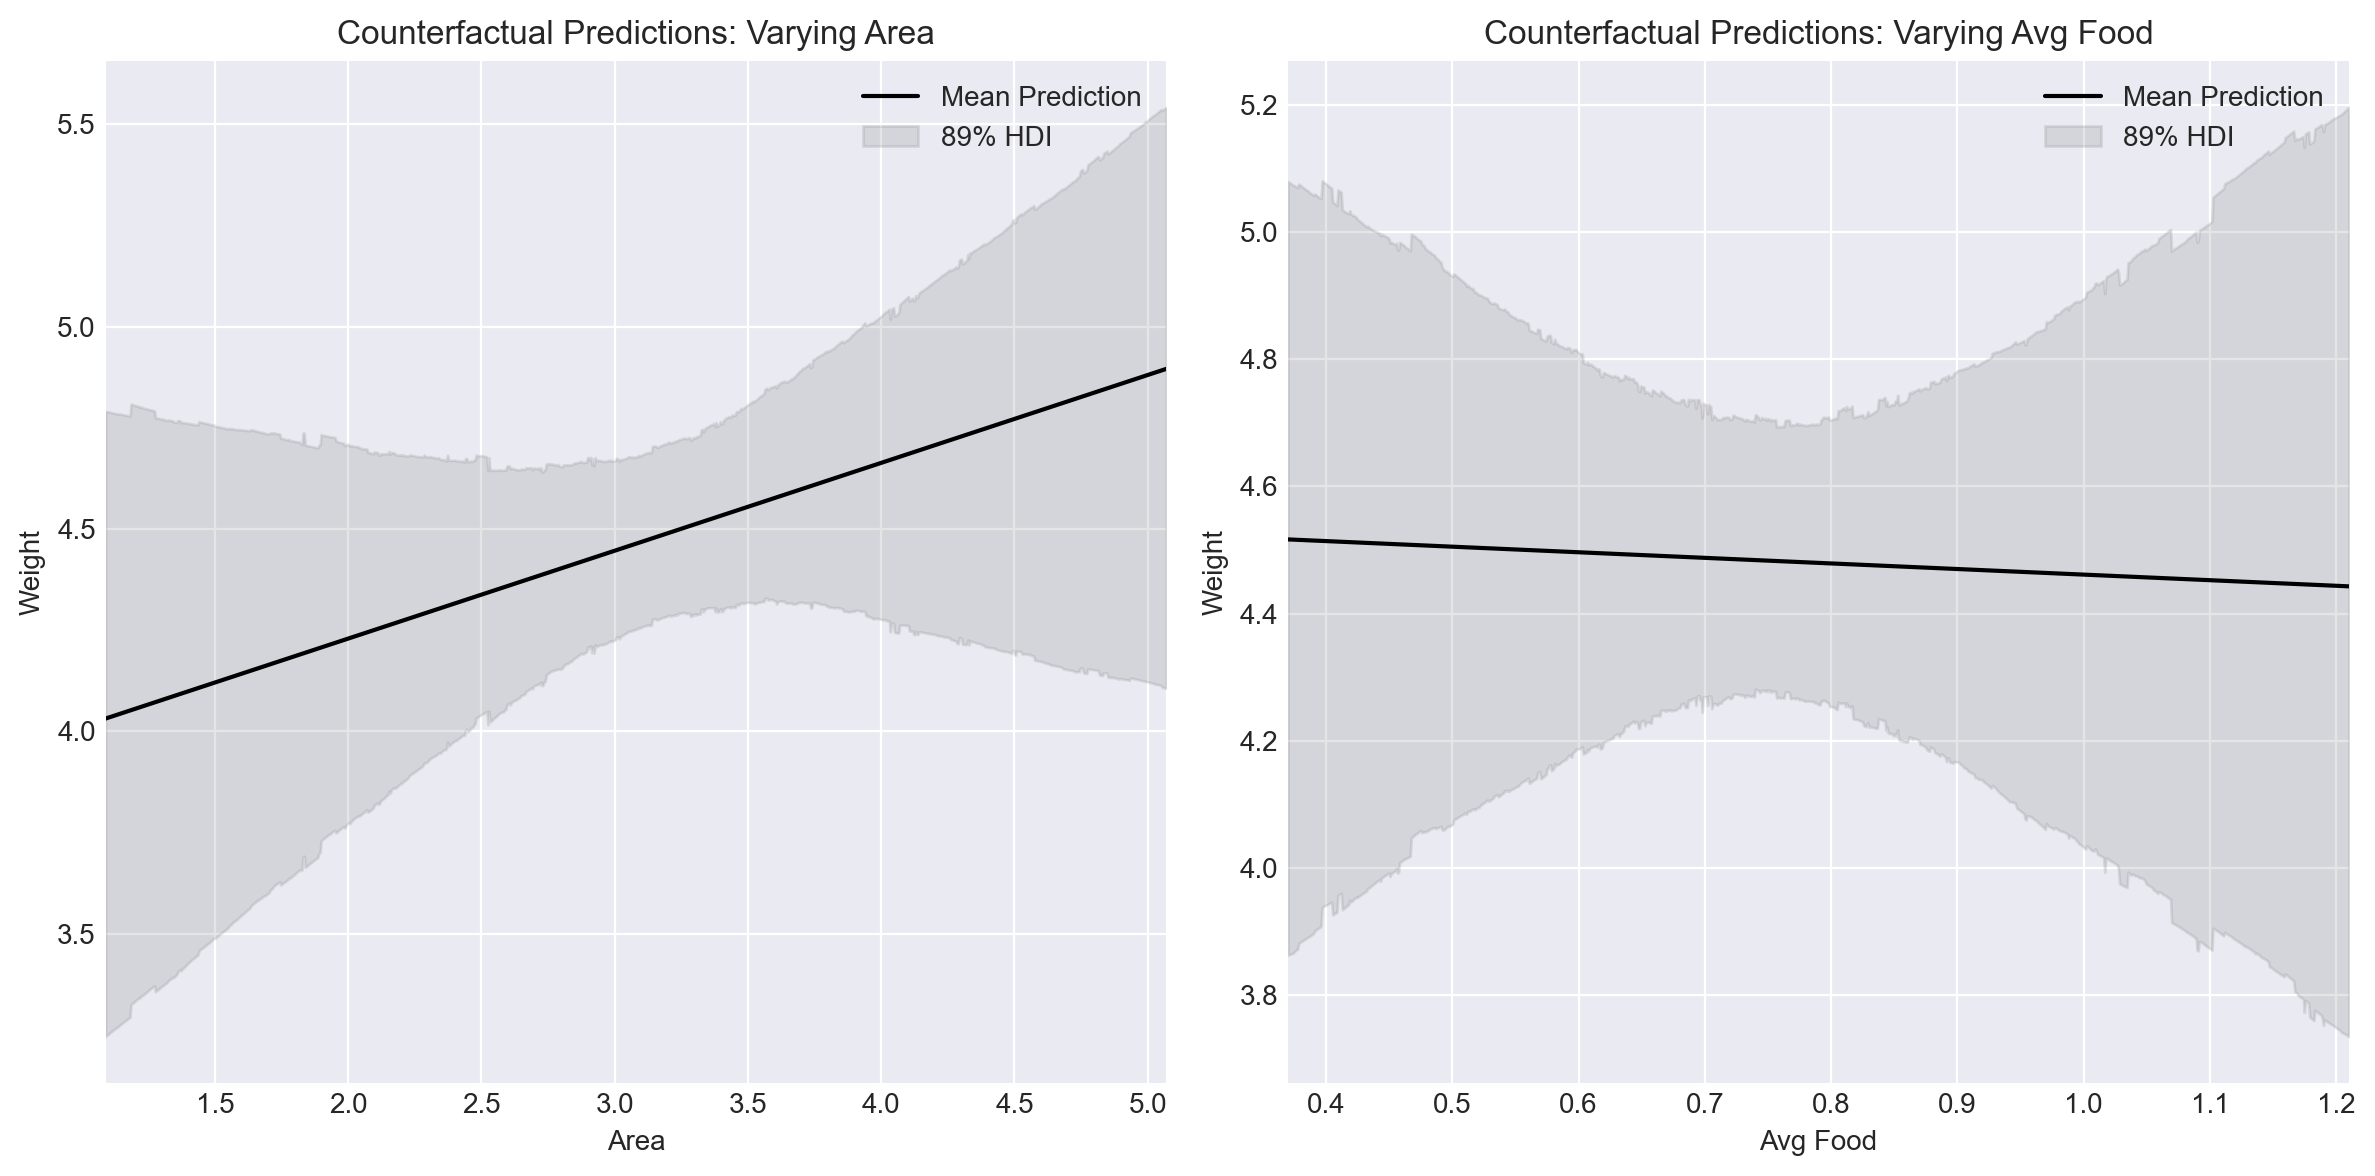

In [364]:
# Extract posterior samples
a_posterior = trace_6.posterior.a.values.flatten()
ba_posterior = trace_6.posterior.ba.values.flatten()
bf_posterior = trace_6.posterior.bf.values.flatten()

# Define dummy sequences for counterfactuals
area_seq = np.linspace(d.area.min(), d.area.max(), 1000)  # Vary area
avgfood_seq = np.linspace(d.avgfood.min(), d.avgfood.max(), 1000)  # Vary groupsize

# Hold the other variable constant at its mean
area_mean = d['area'].mean()
avgfood_mean = d['avgfood'].mean()

# Initialize arrays for counterfactual calculations
n_samples = len(a_posterior)
counterfactual_area = np.zeros((n_samples, len(area_seq)))  # Varying area
counterfactual_avgfood = np.zeros((n_samples, len(avgfood_seq)))  # Varying groupsize

# Calculate counterfactuals
for i in range(n_samples):
    # Counterfactual for varying area (holding groupsize constant)
    counterfactual_area[i] = (
        a_posterior[i]
        + ba_posterior[i] * area_seq
        + bf_posterior[i] * avgfood_mean
    )
    
    # Counterfactual for varying groupsize (holding area constant)
    counterfactual_avgfood[i] = (
        a_posterior[i]
        + ba_posterior[i] * area_mean
        + bf_posterior[i] * avgfood_seq
    )


# Compute mean and credible intervals
mean_area = counterfactual_area.mean(axis=0)
hdi_area = az.hdi(counterfactual_area, hdi_prob=0.95)

mean_avgfood = counterfactual_avgfood.mean(axis=0)
hdi_avgfood = az.hdi(counterfactual_avgfood, hdi_prob=0.95)


print(mean_avgfood.shape)
print(hdi_avgfood.shape)

# Plot counterfactual predictions for area
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1);
plt.plot(area_seq, mean_area, label='Mean Prediction', color='black');
plt.fill_between(area_seq, hdi_area[:, 0], hdi_area[:, 1], color='grey', alpha=0.2, label='89% HDI');
plt.xlim(d.area.min(),d.area.max())
plt.xlabel('Area');
plt.ylabel('Weight');
plt.title('Counterfactual Predictions: Varying Area');
plt.legend()

# Plot counterfactual predictions for groupsize
plt.subplot(1, 2, 2);
plt.plot(avgfood_seq, mean_avgfood, label='Mean Prediction', color='black');
plt.fill_between(avgfood_seq, hdi_avgfood[:, 0], hdi_avgfood[:, 1], color='grey', alpha=0.2, label='89% HDI');
plt.xlim(d.avgfood.min(),d.avgfood.max())
plt.xlabel('Avg Food');
plt.ylabel('Weight');
plt.title('Counterfactual Predictions: Varying Avg Food');
plt.legend()

plt.tight_layout()
plt.show()

,avgfood,area
avgfood,1.000000,0.883104
area,0.883104,1.000000


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

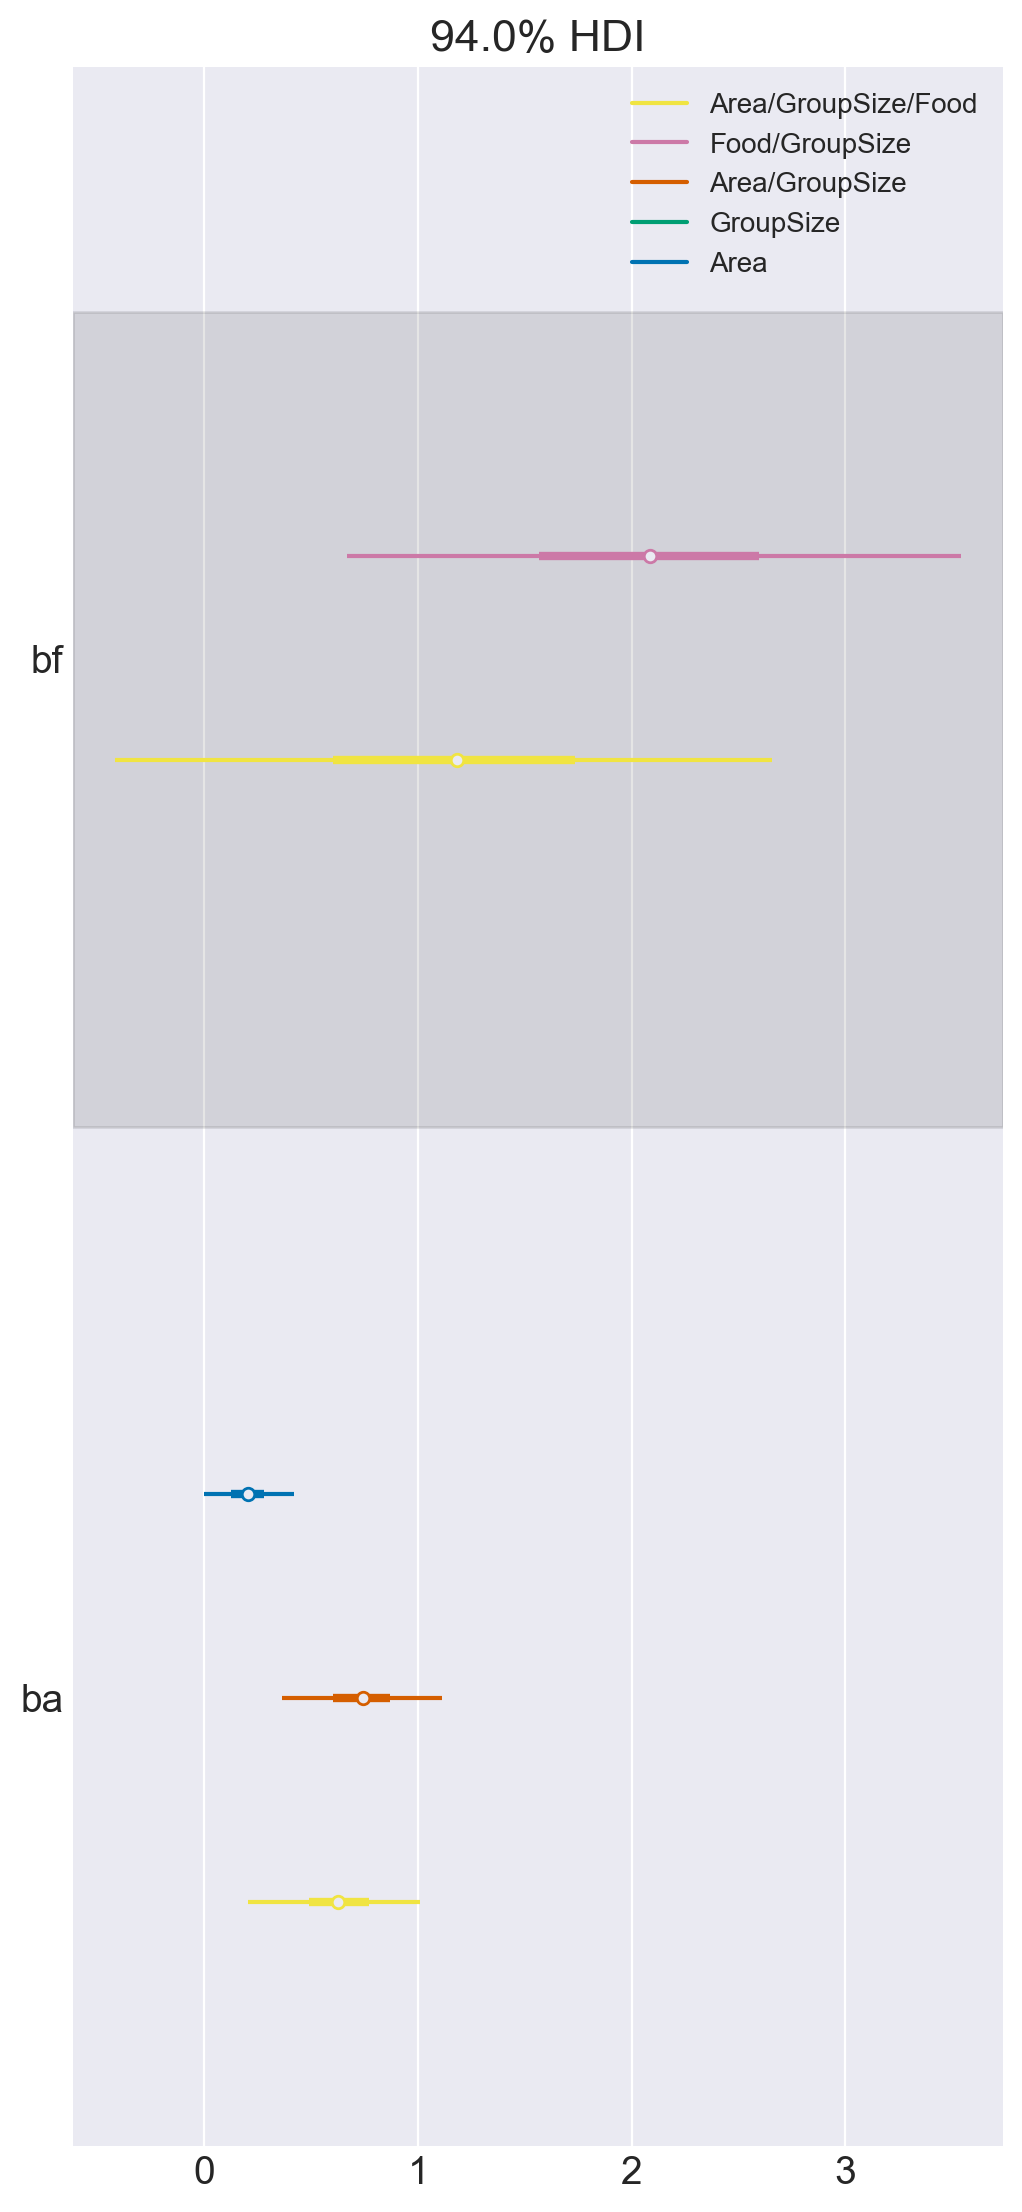

In [350]:
display(d[['avgfood', 'area']].corr())

az.plot_forest([trace, trace_2, trace_3, trace_4, trace_5], 
               combined = True, 
               var_names= ['bf', 'ba'], 
               model_names= ['Area', 'GroupSize', 'Area/GroupSize', 'Food/GroupSize', 'Area/GroupSize/Food'])